In [321]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer

from geopy.distance import geodesic

import holidays

In [322]:
# Carga el dataset en un dataframe
df = pd.read_csv('uber_fares.csv')

# Revisa si hay filas duplicadas
df.duplicated().sum() # 0 filas duplicadas

# Revisa las columnas y sus tipos de datos
df.dtypes


key                    int64
date                  object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [323]:
# Asigna el tipo de datos correcto a las variables que representan fechas
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.floor('s')
df['date'] = pd.to_datetime(df['date']).dt.floor('s')

# Muestra las primeras filas del dataframe
df.head()

key                date  fare_amount           pickup_datetime  \
0  24238194 2015-05-07 19:52:06          7.5 2015-05-07 19:52:06+00:00   
1  27835199 2009-07-17 20:04:56          7.7 2009-07-17 20:04:56+00:00   
2  44984355 2009-08-24 21:45:00         12.9 2009-08-24 21:45:00+00:00   
3  25894730 2009-06-26 08:22:21          5.3 2009-06-26 08:22:21+00:00   
4  17610152 2014-08-28 17:47:00         16.0 2014-08-28 17:47:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.999817        40.738354         -73.999512         40.723217   
1        -73.994355        40.728225         -73.994710         40.750325   
2        -74.005043        40.740770         -73.962565         40.772647   
3        -73.976124        40.790844         -73.965316         40.803349   
4        -73.925023        40.744085         -73.973082         40.761247   

   passenger_count  
0                1  
1                1  
2                1  
3                3  
4                5

# Limpieza y preprocesamiento

In [324]:
# Elimina la columna 'key' que no aporta información relevante
df = df.drop(columns=['key'])

# Chequea si las columnas 'pickup_datetime' y 'date' son iguales
df['pickup_datetime'].equals(df['date']) # True

# Elimina la columna 'pickup_datetime' ya que es redundante
df = df.drop(columns=['pickup_datetime'])

In [325]:
# Elimina las filas cuya variable objetivo no es un valor posible
df = df[df['fare_amount'] > 0] # 0.01% de los datos

#### Null Island
Isla ficticia, ubicada en 0°N 0°E, que los GPS suelen utilizar como ubicación por defecto cuando fallan y no pueden determinar la ubicación real, es decir, representa una ubicación nula.

In [326]:
df_sin_null_island = df[
    ~(
        (df['pickup_latitude'] == 0) & (df['pickup_longitude'] == 0) |
        (df['dropoff_latitude'] == 0) & (df['dropoff_longitude'] == 0)
    )
]

print(f"Los viajes que comenzaron o terminaron en Null Island representan el {100 * (1 - df_sin_null_island.shape[0] / df.shape[0]):.2f}% de los datos.")

Los viajes que comenzaron o terminaron en Null Island representan el 1.97% de los datos.


In [327]:
# Elimina las filas que corresponden a viajes que empezaron o terminaron en Null Island
df = df_sin_null_island

### Visualización de las variables de coordenadas

In [328]:
# Genera un nuevo dataframe con todas las coordenadas
coordenadas = pd.concat(
    [
        df[['pickup_latitude', 'pickup_longitude']].rename(
            columns={'pickup_latitude': 'latitude', 'pickup_longitude': 'longitude'}
        ).assign(type='pickup'),
        df[['dropoff_latitude', 'dropoff_longitude']].rename(
            columns={'dropoff_latitude': 'latitude', 'dropoff_longitude': 'longitude'}
        ).assign(type='dropoff')
    ], ignore_index=True
)

# Muestra un mapa de las ubicaciones de inicio y fin del viaje
fig = px.scatter_map(
    coordenadas.sample(50000),
    lat="latitude",
    lon="longitude",
    color="type",
    zoom=5,
    title="Ubicaciones"
)

fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r":0,"t":30,"l":0,"b":0}  # elimina márgenes blancos
)
fig.show()


A simple vista se observa que hay una gran densidad de viajes en Nueva York

In [329]:
limites_ny = {
    'lat_min': 40.49,
    'lat_max': 40.92,
    'lon_min': -74.27,
    'lon_max': -73.68
}

cantidad_viajes = df.shape[0]

# Filtra los viajes que se dieron de los límites de Nueva York
df_ny = df[
    (df['pickup_latitude'] >= limites_ny['lat_min']) &
    (df['pickup_latitude'] <= limites_ny['lat_max']) &
    (df['pickup_longitude'] >= limites_ny['lon_min']) &
    (df['pickup_longitude'] <= limites_ny['lon_max']) &
    (df['dropoff_latitude'] >= limites_ny['lat_min']) &
    (df['dropoff_latitude'] <= limites_ny['lat_max']) &
    (df['dropoff_longitude'] >= limites_ny['lon_min']) &
    (df['dropoff_longitude'] <= limites_ny['lon_max'])
]
cantidad_viajes_ny = df_ny.shape[0]

print(f"Los viajes dentro de los límites de Nueva York representan el {cantidad_viajes_ny / cantidad_viajes * 100:.2f}% del total.")


Los viajes dentro de los límites de Nueva York representan el 99.74% del total.


Vamos a reducir el alcance de nuestro modelo predictivo a viajes íntegramente dentro de la ciudad de Nueva York ya que representan un 99.54 % de los datos. Así podremos garantizar mejores resultado. 

In [330]:
# Elimina las filas que corresponden a viajes que no se dieron dentro de los límites de Nueva York
df = df_ny

Los valores posibles para la variable *passenger_count* están en el rango [0;6]. (UberX permite hasta 4 y UberXL hasta 6).

In [331]:
# Análisis de viajes con cantidad de pasajeros no válida
df[(df['passenger_count'] > 6)]

date  fare_amount  pickup_longitude  pickup_latitude  \
113038 2010-12-28 08:20:00         11.7        -73.937795        40.758498   

        dropoff_longitude  dropoff_latitude  passenger_count  
113038         -73.937835         40.758415              208

In [332]:
# Elimina la fila con passenger_count = 208, que es la única con valor absurdo.
df = df[df['passenger_count'] <= 6]

In [333]:
print(f"Hasta este momento eliminamos un {100 - df.shape[0] / 200000 * 100:.2f}% de los datos.")

Hasta este momento eliminamos un 2.24% de los datos.


### Generación de variable distancia

In [334]:
def imputar_distancia(viaje):
    '''
    Calcula la distancia en kilómetros del viaje
    mediante una combinación de distancia Manhattan con
    distancia geodésica (teniendo en cuenta la curvatura
    de la Tierra.)
    '''
    lat1 = viaje['pickup_latitude']
    lon1 = viaje['pickup_longitude']
    lat2 = viaje['dropoff_latitude']
    lon2 = viaje['dropoff_longitude']

    distancia_lat = np.float32(geodesic((lat1, lon1), (lat2, lon1)).kilometers)
    distancia_lon = np.float32(geodesic((lat2, lon1), (lat2, lon2)).kilometers)

    return distancia_lat + distancia_lon

df['distance'] = df.apply(imputar_distancia, axis=1)

### Split Train/Test

In [335]:
# Separa el 80% para train y 20% para test
train, test= train_test_split(df, test_size=0.2, random_state=1)

## EDA

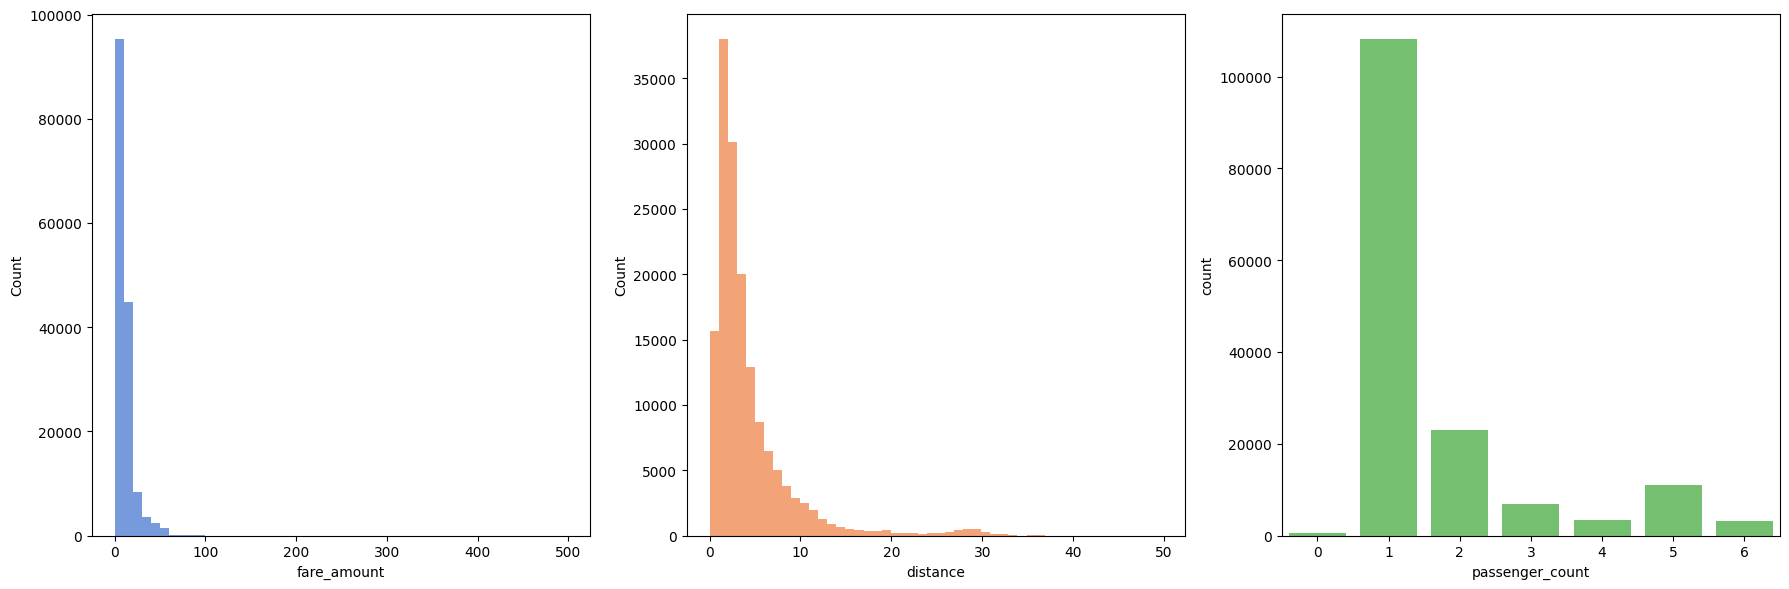

In [336]:
# Distribución de variables
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(data=train, x='fare_amount', bins=50, color=sns.color_palette("muted")[0], ax=axes[0], edgecolor='none')
sns.histplot(data=train, x='distance', bins=50, color=sns.color_palette("muted")[1], ax=axes[1], edgecolor='none')
sns.countplot(data=train, x='passenger_count', color=sns.color_palette("muted")[2], ax=axes[2])

plt.tight_layout()
plt.show()

Se observa que tanto *fare_amount* como *distance* están sesgadas hacía la derecha. Vamos a tratar sus outliers.

### Tratado de Outliers

#### Variable *fare_amount*

In [337]:
train['fare_amount'].describe(percentiles=[0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999])

count    156420.000000
mean         11.284068
std           9.503064
min           0.010000
0.1%          2.500000
1%            3.300000
5%            4.100000
25%           6.000000
50%           8.500000
75%          12.500000
95%          30.000000
99%          52.000000
99.9%        75.000000
max         499.000000
Name: fare_amount, dtype: float64

<Axes: xlabel='fare_amount', ylabel='Count'>

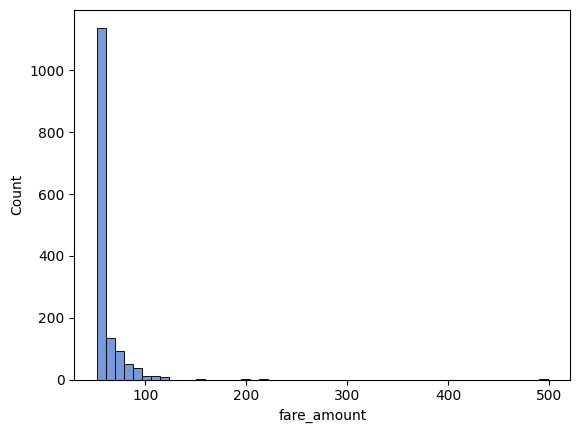

In [338]:
# Análisis de tarifas mayores al 99% de los datos.
sns.histplot(data=train[train['fare_amount'] > 52], x='fare_amount', bins=50, color=sns.color_palette("muted")[0])

Dentro del 1% de las tarifas más altas observamos una disminución brusca de frecuencia al superar el umbral de los 75 dólares (0.01% de los datos). Vamos a transformar dichos valores en null para su posterior imputación.

In [339]:
train['fare_amount'] = np.where(train['fare_amount'] > 75, np.nan, train['fare_amount'])
test['fare_amount'] = np.where(test['fare_amount'] > 75, np.nan, test['fare_amount'])

In [340]:
# Análisis de las tarifas hasta el percentil 1%
train[train['fare_amount'] <= 3.3]['fare_amount'].value_counts()

fare_amount
3.30    1089
2.50     573
2.90     366
3.00     284
0.01       2
0.11       1
Name: count, dtype: int64

Se observan 2 valores de tarifa muy inferiores en valor y frecuencia a los demás datos. Las reemplazamos por nulos para para su posterior imputación

In [341]:
train['fare_amount'] = np.where(train['fare_amount'] < 1, np.nan, train['fare_amount'])
test['fare_amount'] = np.where(test['fare_amount'] < 1, np.nan, test['fare_amount'])

#### Variable *distance*

In [342]:
train['distance'].describe()

count    156420.000000
mean          4.262475
std           4.698390
min           0.000000
25%           1.602829
50%           2.770420
75%           5.036725
max          49.804722
Name: distance, dtype: float64

La distancia del viaje no puede ser 0, porque no habría viaje. Asumimos que corresponden a viajes que comienzan y terminan en la misma ubicación pero tienen un recorrido con paradas intermedias, como no tenemos información sobre paradas intermedias, reemplazamos los valores 0 de distancia por nulos para su posterior imputación.

In [343]:
train = train.assign(distance=lambda x: x['distance'].replace(0, np.nan))
test = test.assign(distance=lambda x: x['distance'].replace(0, np.nan))

# Estadísticas descriptivas de distancias no nulas
train['distance'].describe(percentiles=[0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999])

count    154850.000000
mean          4.305691
std           4.702405
min           0.000084
0.1%          0.001935
1%            0.283168
5%            0.777522
25%           1.631325
50%           2.798514
75%           5.078414
95%          12.365005
99%          28.009501
99.9%        31.981878
max          49.804722
Name: distance, dtype: float64

No vamos a considerar como válida ninguna distancia menor a 0.1km. Reemplazamos por null para posterior imputación.

In [344]:
train['distance'] = np.where(train['distance'] < 0.1, np.nan, train['distance'])
test['distance'] = np.where(test['distance'] < 0.1, np.nan, test['distance'])

In [345]:
# Descarta viajes sin tarifa y sin distancia. No imputables.
train = train[~(train['fare_amount'].isnull() & train['distance'].isnull())]

In [346]:
# Porcentaje de datos borrados
cantidad_datos = train.shape[0] + test.shape[0]
print(f"Porcentaje total de datos borrados: {100 - cantidad_datos / 200000 * 100:.2f}%.")

Porcentaje total de datos borrados: 2.25%.


### Ingeniería de características

#### Variable *date*

In [347]:
train['hour'] = train['date'].dt.hour
train['day'] = train['date'].dt.day_of_week
train['month'] = train['date'].dt.month

test['hour'] = test['date'].dt.hour
test['day'] = test['date'].dt.day_of_week
test['month'] = test['date'].dt.month

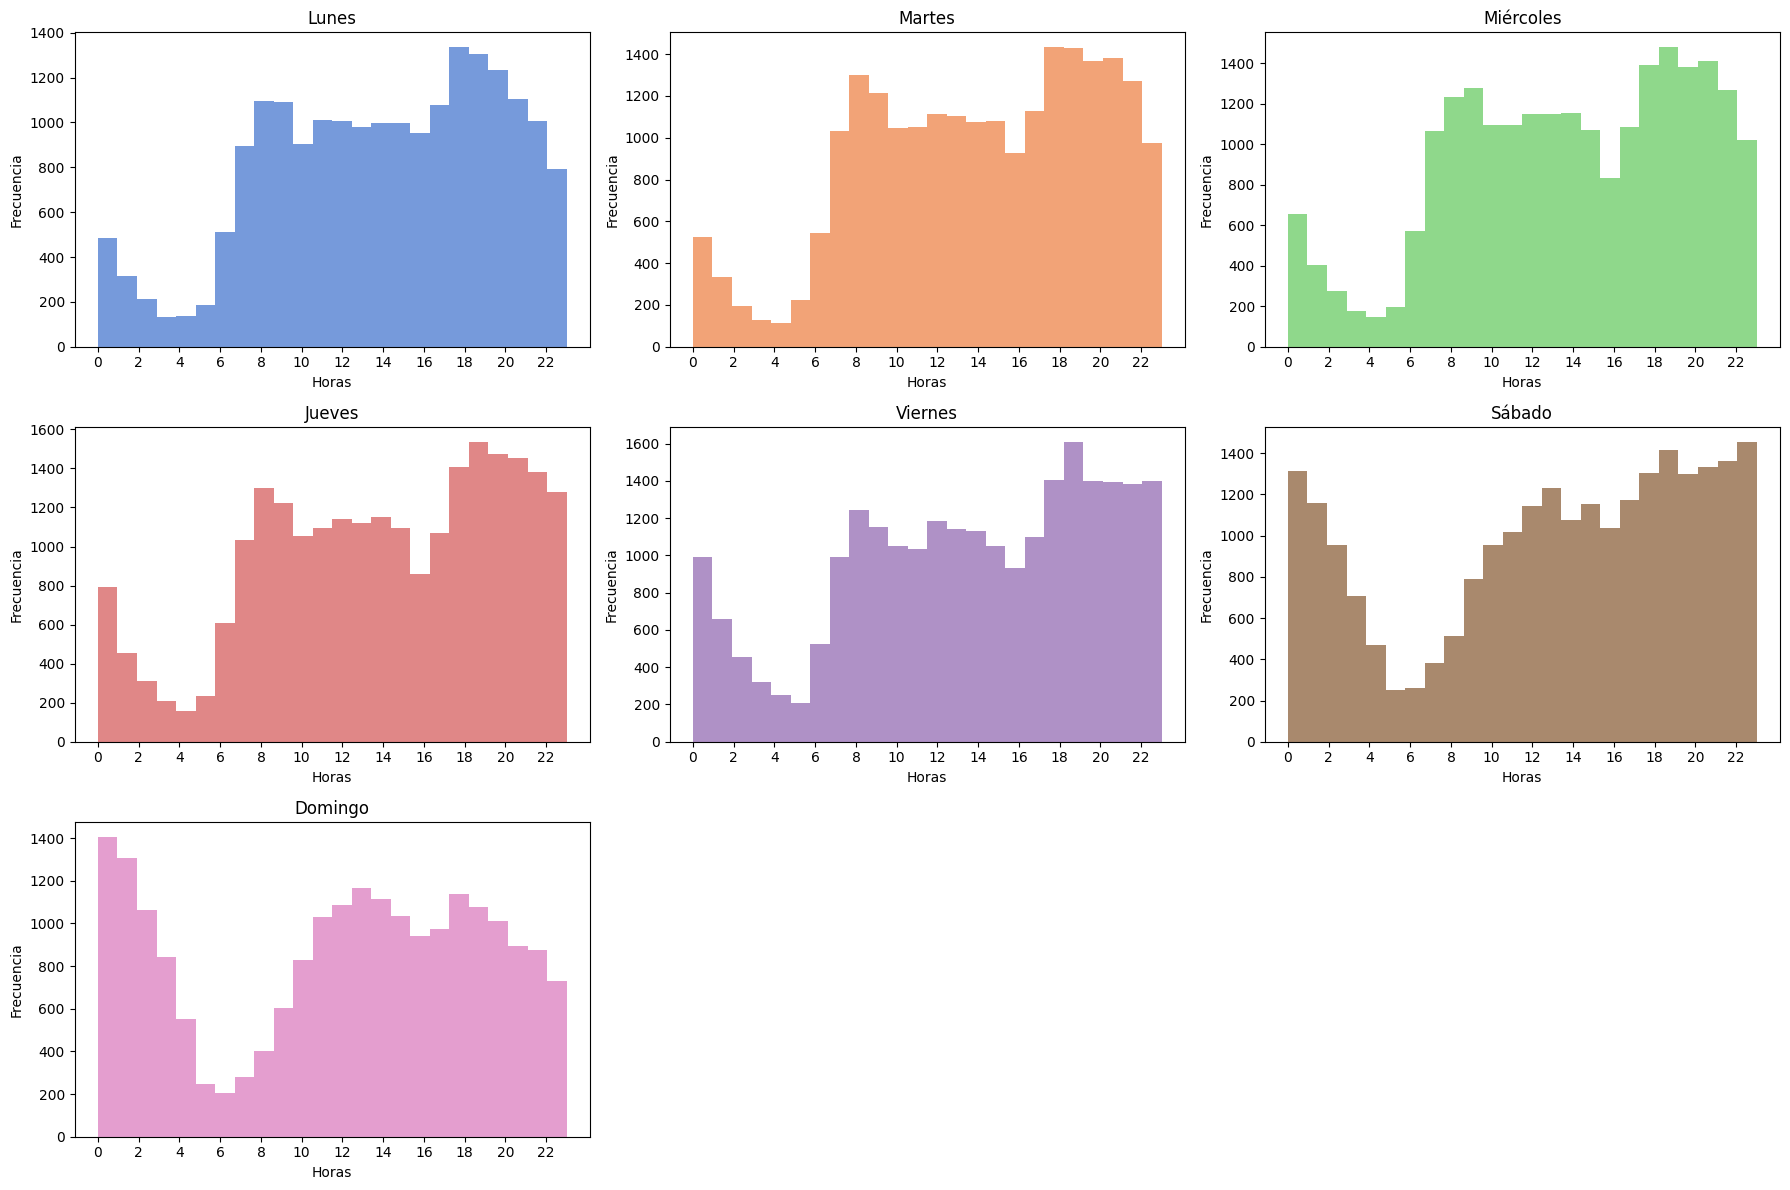

In [348]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

dias_semana = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

for i, dia in enumerate(dias_semana):
    ax = axes[i // 3, i % 3]
    sns.histplot(
        data=train[train["day"] == i],
        x="hour",
        bins=24,
        color=sns.color_palette("muted", 7)[i],
        edgecolor="none",
        ax=ax
    )
    ax.set_title(dia)
    ax.set_xlabel("Horas")
    ax.set_ylabel("Frecuencia")
    ax.set_xticks(range(0, 24, 2))

fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

plt.tight_layout()
plt.show()

Se observa que los días Lunes, Martes y Miércoles presentan una distribución muy parecida, con una rápida diminución de viajes luego de las 22 horas.


Los Jueves, Viernes y Sábados presentan una mayor cantidad de actividad en horarios nocturnos, y un aumento en la demanda luego de las 22 horas, especialmente los viernes y sábados.


Los domingos presentan un comportamiento único, teníendo su momento de mayor actividad a la madrugada y una baja de actividad a partir de las 18.

In [349]:
# Genera variables dummies de grupos de dias de la semana con distribuciones similares
train['is_mon_tue_wed'] = np.where(train['day'].isin([0, 1, 2]), 1, 0)
train['is_thu_fri_sat'] = np.where(train['day'].isin([3, 4, 5]), 1, 0)

test['is_mon_tue_wed'] = np.where(test['day'].isin([0, 1, 2]), 1, 0)
test['is_thu_fri_sat'] = np.where(test['day'].isin([3, 4, 5]), 1, 0)

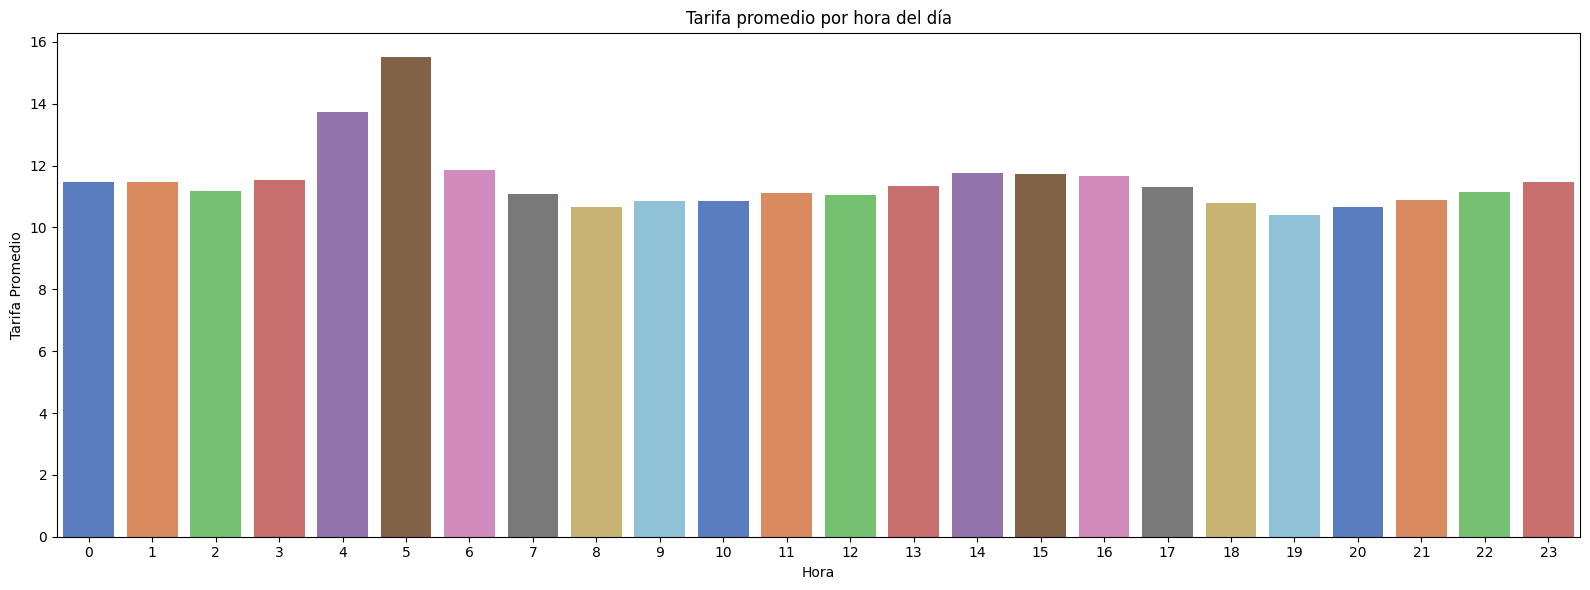

In [350]:
tarifa_promedio_por_hora = train.groupby("hour")['fare_amount'].mean().reset_index(name="promedio")

plt.figure(figsize=(16, 6))
sns.barplot(
    data=tarifa_promedio_por_hora,
    x="hour",
    y="promedio",
    hue="hour",
    palette="muted",
    legend=False
)

plt.title("Tarifa promedio por hora del día")
plt.xlabel("Hora")
plt.ylabel("Tarifa Promedio")

plt.tight_layout()
plt.show()

Las tarifas promedio más altas se dan entre las 4 y 5 de la madrugada de forma acentuada por sobre el resto de las horas del día.

In [351]:
# Genera variable dummy para indicar horario de madrugada
train['is_early_morning'] = np.where(train['hour'].isin([4, 5]), 1, 0)

test['is_early_morning'] = np.where(test['hour'].isin([4, 5]), 1, 0)

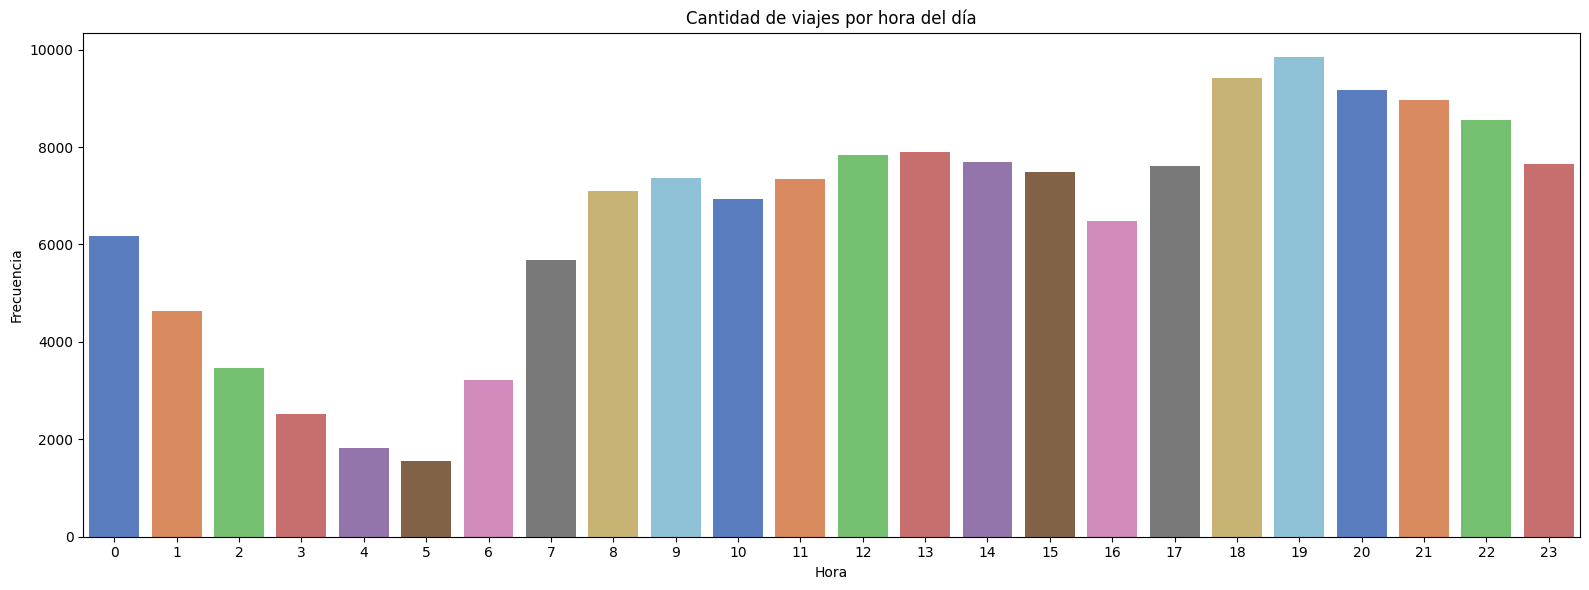

In [352]:
viajes_por_hora = train.groupby("hour")['fare_amount'].size().reset_index(name="frecuencia")

plt.figure(figsize=(16, 6))
sns.barplot(
    data=viajes_por_hora,
    x="hour",
    y="frecuencia",
    hue="hour",
    palette="muted",
    legend=False
)

plt.title("Cantidad de viajes por hora del día")
plt.xlabel("Hora")
plt.ylabel("Frecuencia")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [353]:
train['hour'].value_counts().head(10)

hour
19    9852
18    9408
20    9172
21    8974
22    8549
13    7894
12    7831
14    7692
23    7654
17    7604
Name: count, dtype: int64

El horario de mayor actividad general se da marcadamente entre las 18 y las 22.

In [354]:
# Genera variable dummy de alta actividad
train['is_high_activity'] = np.where(train['hour'].isin([18, 19, 20, 21, 22]), 1, 0)

test['is_high_activity'] = np.where(test['hour'].isin([18, 19, 20, 21, 22]), 1, 0)

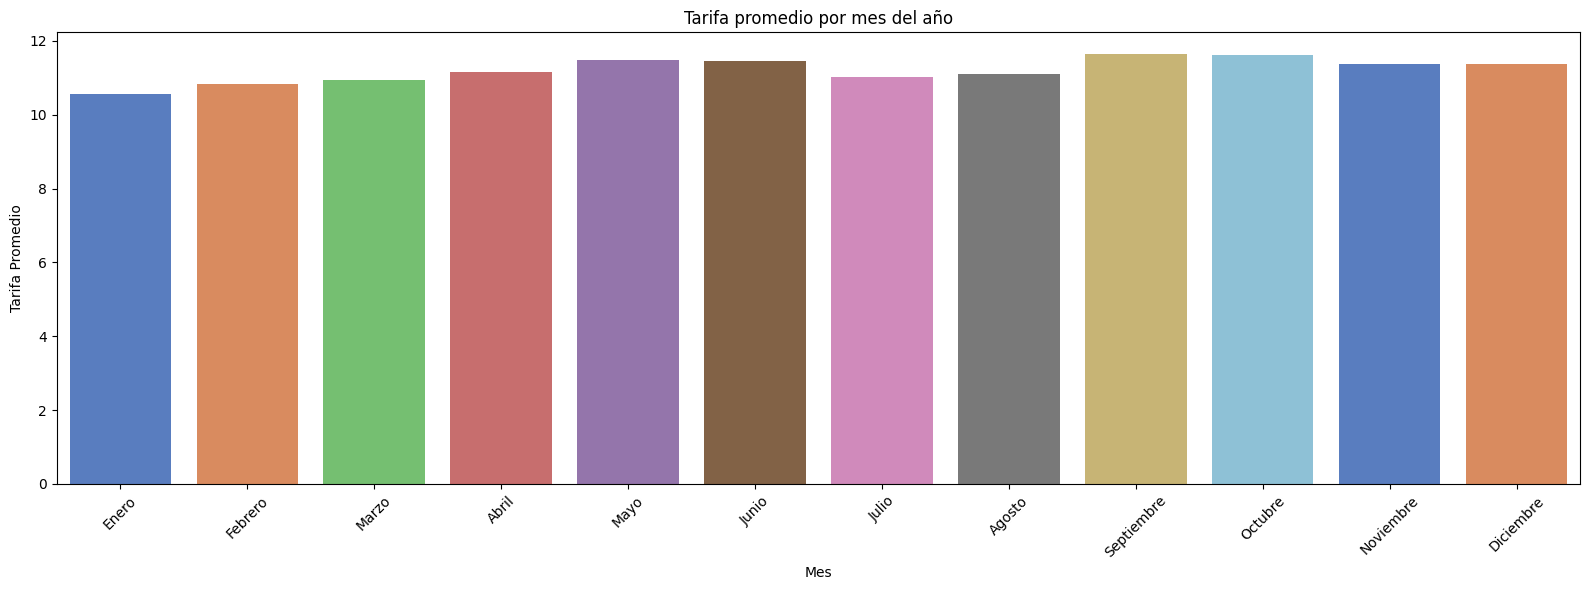

In [355]:
tarifa_promedio_por_mes = train.groupby("month")['fare_amount'].mean().reset_index(name="promedio")

plt.figure(figsize=(16, 6))
sns.barplot(
    data=tarifa_promedio_por_mes,
    x="month",
    y="promedio",
    hue="month",
    palette="muted",
    legend=False,
)

plt.xticks(
    ticks=range(12),
    labels=["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"],
    rotation=45
)

plt.title("Tarifa promedio por mes del año")
plt.xlabel("Mes")
plt.ylabel("Tarifa Promedio")

plt.tight_layout()
plt.show()

La tarifa promedio a lo largo de los meses no muestra ninguna tendencia o particularidad clara por lo que decidimos no incluir ninguna variable relacionada para reducir el riesgo de overfitting.

In [356]:
# Crea variable dummy para identificar viajes en días feriados
us_holidays = holidays.US(years=train["date"].dt.year.unique(), state="NY")
train["is_holiday"] = train["date"].dt.date.isin(us_holidays)

In [357]:
train.groupby("is_holiday")['fare_amount'].describe()

count       mean       std  min  25%  50%   75%   max
is_holiday                                                          
False       151465.0  11.204188  9.075849  2.5  6.0  8.5  12.5  75.0
True          4807.0  11.306961  9.512507  2.5  6.0  8.5  12.5  75.0

El hecho de que sea o no feriado no parece afectar el valor de la tarifa. por lo que decidimos eliminarla para reducir el riesgo de overfitting.

In [358]:
train.drop(columns=['is_holiday'], inplace=True)

#### Variable *passenger_count*

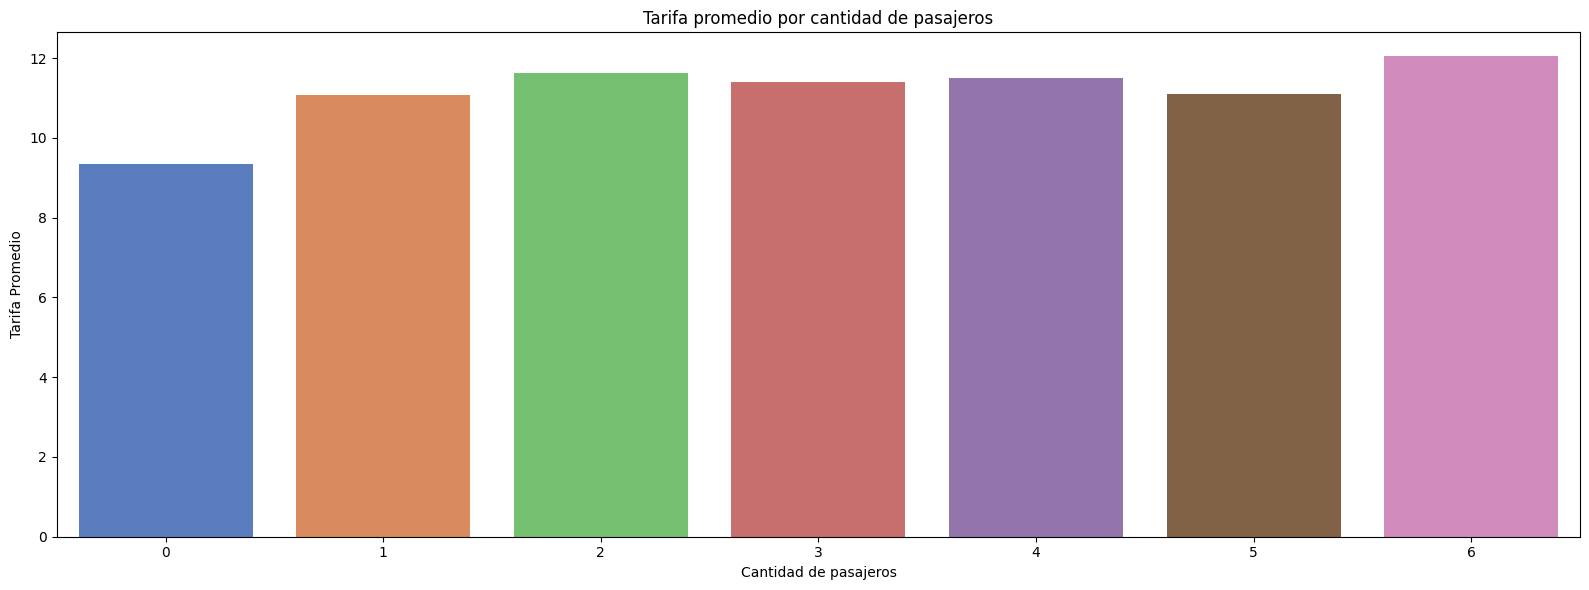

In [359]:
tarifa_promedio_por_cantidad_pasajeros = train.groupby("passenger_count")['fare_amount'].mean().reset_index(name="promedio")

plt.figure(figsize=(16, 6))
sns.barplot(
    data=tarifa_promedio_por_cantidad_pasajeros,
    x="passenger_count",
    y="promedio",
    hue="passenger_count",
    palette="muted",
    legend=False,
)

plt.title("Tarifa promedio por cantidad de pasajeros")
plt.xlabel("Cantidad de pasajeros")
plt.ylabel("Tarifa Promedio")

plt.tight_layout()
plt.show()

Si bien la cantidad exacta de pasajeros de un viaje es un dato desconocido antes de concretar el viaje, si sabemos que los viajes con 0 pasajeros son envíos mediante "Uber Flash", y los viajes de 5 o 6 pasajeros necesitan vehículos aprobados y se solicitan bajo el nombre "Uber XL". Esta información sí se tiene disponible al momento de solicitar el viaje, ya que forma parte de los parámetros que configuran al mismo. 


A priori se observa que el promedio de tarifa de cadetería mediante "Uber Flash" es inferior a cualquier viaje con pasajeros.

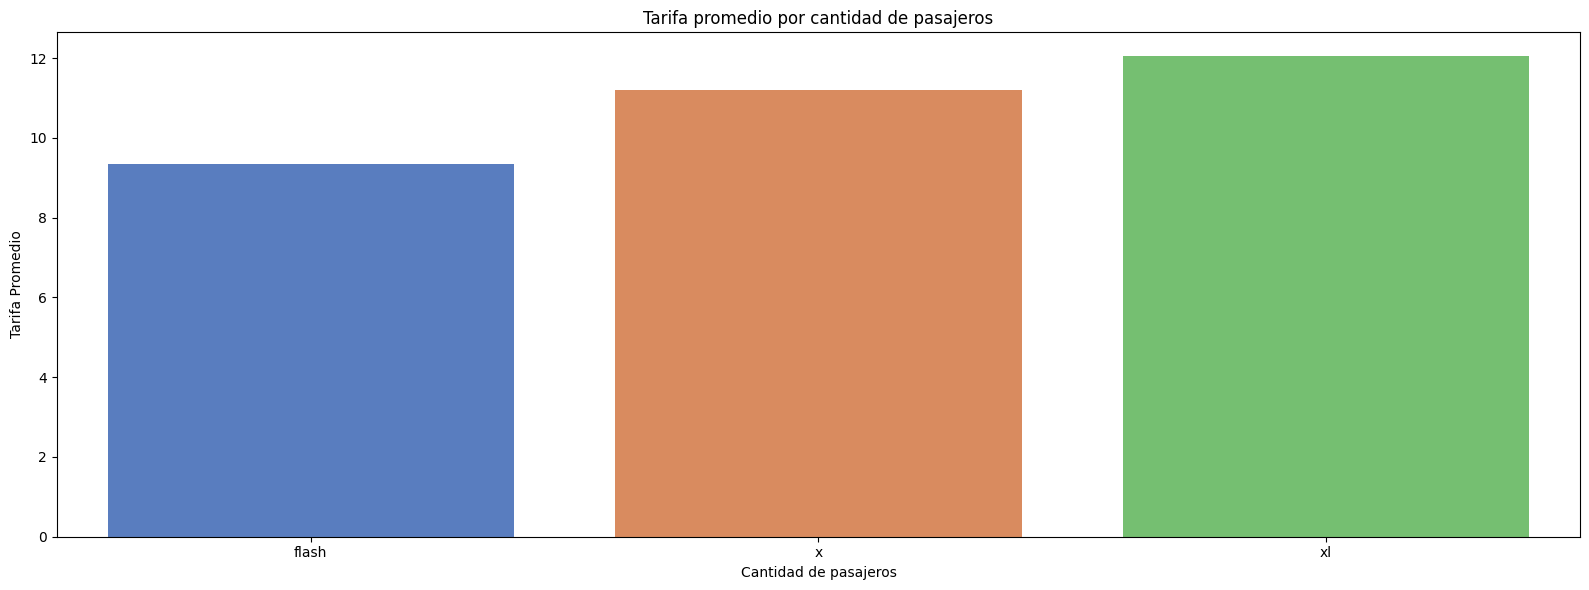

In [360]:
train['type_of_service'] = np.where(train['passenger_count'] == 0, 'flash',
                                    np.where(train['passenger_count'] > 5, 'xl', 'x'))

test['type_of_service'] = np.where(test['passenger_count'] == 0, 'flash',
                                    np.where(test['passenger_count'] > 5, 'xl', 'x'))

tarifa_promedio_por_cantidad_pasajeros = train.groupby("type_of_service")['fare_amount'].mean().reset_index(name="promedio")

plt.figure(figsize=(16, 6))
sns.barplot(
    data=tarifa_promedio_por_cantidad_pasajeros,
    x="type_of_service",
    y="promedio",
    hue="type_of_service",
    palette="muted",
    legend=False,
)

plt.title("Tarifa promedio por cantidad de pasajeros")
plt.xlabel("Cantidad de pasajeros")
plt.ylabel("Tarifa Promedio")

plt.tight_layout()
plt.show()

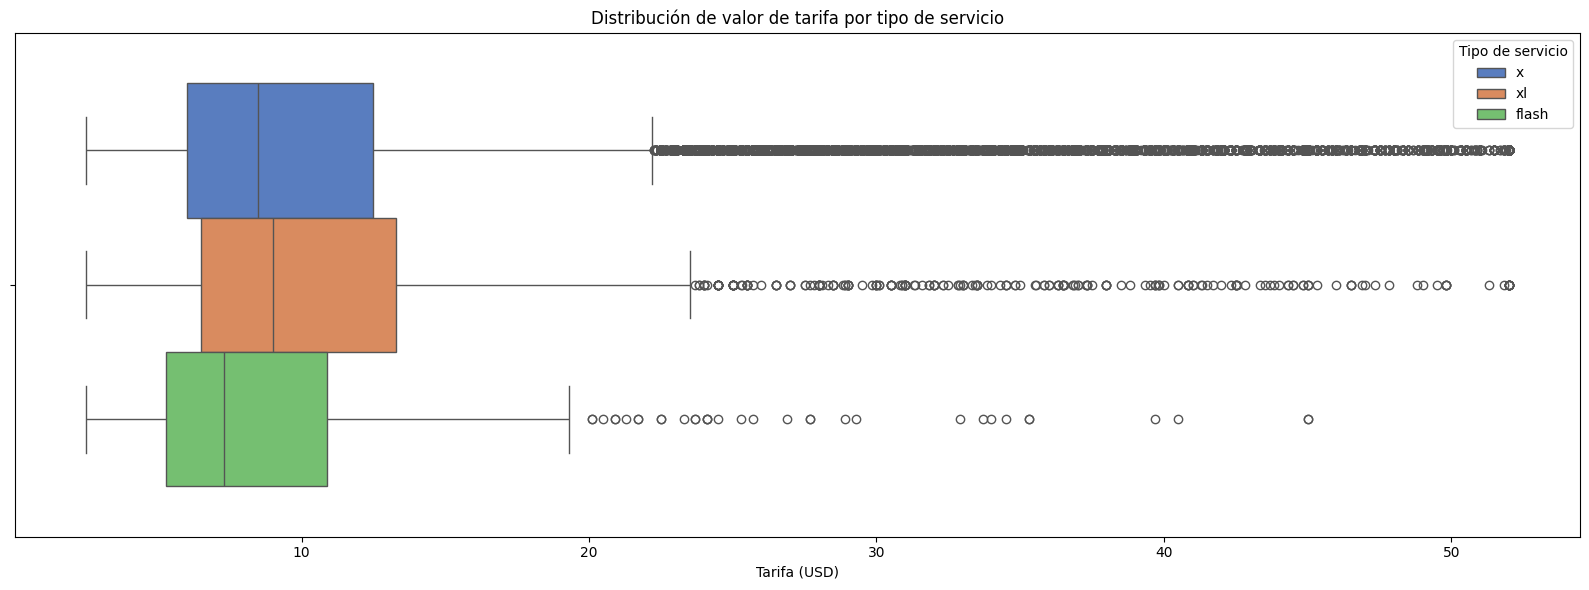

In [361]:
plt.figure(figsize=(16, 6))

sns.boxplot(
    data=train[train['fare_amount'].quantile(0.99) >= train['fare_amount']], # Omite outliers para mejor visualización
    x='fare_amount',
    hue='type_of_service',
    palette='muted',
)

plt.title('Distribución de valor de tarifa por tipo de servicio')
plt.xlabel('Tarifa (USD)')
plt.legend(title='Tipo de servicio')
plt.tight_layout()
plt.show()

Se observan diferencias claras entre las tarifas de los distintos servicios, consistentemente las tarifas de servicio "Uber Flash" son inferiores a las de "Uber X", que son inferiores a las de "Uber XL". Vamos a considerar esta información para el modelo mediante el uso de variables dummys.

In [362]:
# Genera dummys para tipo de servicio
train['is_xl'] = np.where(train['type_of_service'] == 'xl', 1, 0)
train['is_flash'] = np.where(train['type_of_service'] == 'flash', 1, 0)

test['is_xl'] = np.where(test['type_of_service'] == 'xl', 1, 0)
test['is_flash'] = np.where(test['type_of_service'] == 'flash', 1, 0)

### Escalado

In [363]:
scaler = StandardScaler()
scaler.fit(train[['distance', 'fare_amount']])

train[['distance', 'fare_amount']] = scaler.transform(train[['distance', 'fare_amount']])
test[['distance', 'fare_amount']] = scaler.transform(test[['distance', 'fare_amount']])

### Imputación

In [364]:
print(f'Se imputarán {(train.isna().sum().sum() + test.isna().sum().sum())} datos, que se corresponde con el {100 * (train.isna().sum().sum() + test.isna().sum().sum()) / (train.size + test.size):.2f}% del dataset.')

Se imputarán 3133 datos, que se corresponde con el 0.09% del dataset.


In [365]:
# Imputa los valores faltantes de las variables numéricas fare_amount y distance mediante KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputer.fit(train[['distance', 'fare_amount']])

train[['distance', 'fare_amount']] = imputer.transform(train[['distance', 'fare_amount']])
test[['distance', 'fare_amount']] = imputer.transform(test[['distance', 'fare_amount']])


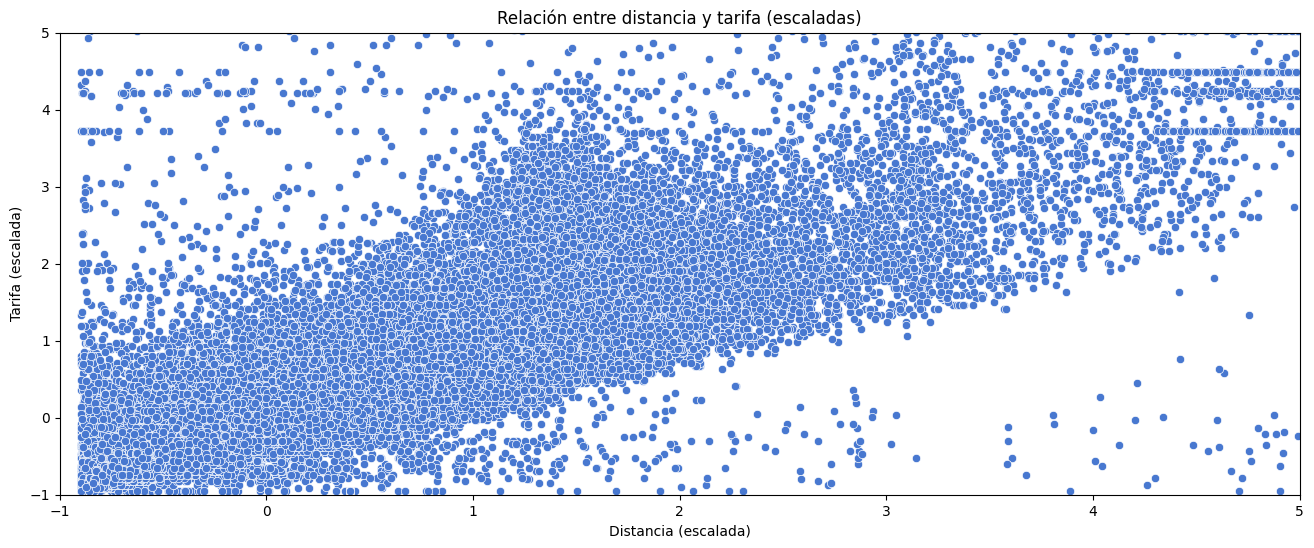

In [366]:
plt.figure(figsize=(16, 6))

sns.scatterplot(
    data=train,
    x='distance',
    y='fare_amount',
    color=sns.color_palette("muted")[0],
)

plt.xlim(-1, 5)
plt.ylim(-1, 5)
plt.xlabel("Distancia (escalada)")
plt.ylabel("Tarifa (escalada)")
plt.title("Relación entre distancia y tarifa (escaladas)")
plt.show()

## PreTrain

In [367]:
train.columns

Index(['date', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance',
       'hour', 'day', 'month', 'is_mon_tue_wed', 'is_thu_fri_sat',
       'is_early_morning', 'is_high_activity', 'type_of_service', 'is_xl',
       'is_flash'],
      dtype='object')

In [368]:
# Elimina columnas que no se van a utilizar en el modelo
train.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'type_of_service', 'date', 'hour', 'day', 'month'], inplace=True)
test.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'type_of_service', 'date', 'hour', 'day', 'month'], inplace=True)

# Entrenamiento de Modelos

In [369]:
x_train = train.drop(columns=['fare_amount'])
y_train = train['fare_amount']

x_test = test.drop(columns=['fare_amount'])
y_test = test['fare_amount']

In [370]:
rmse_modelos = []
mae_modelos = []

## Regresión Lineal


### OLS

In [371]:
lr = LinearRegression()

In [372]:
r2_train = cross_val_score(lr, x_train, y_train, cv=5).mean()
print(f"R2 en train cross-validation: {r2_train:.4f}")

lr.fit(x_train, y_train)
y_test_pred = lr.predict(x_test)

R2 en train cross-validation: 0.7974


El modelo explica aproximadamente el 80.13% de la variabilidad de tarifas en los datos de entrenamiento aplicando validación cruzada 5-fold.

In [373]:
# Reescala las predicciones y los valores reales de tarifa (variable target)
y_test_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_test_pred_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test_pred), y_test_pred)))[:, 1]

In [374]:
r2 = r2_score(y_test_original, y_test_pred_original)
mse = mean_squared_error(y_test_original, y_test_pred_original)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_original - y_test_pred_original))

rmse_modelos.append(rmse)
mae_modelos.append(mae)

print(f"Train R²: {r2_train:.4f}")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Train R²: 0.7974
R²: 0.7985
MSE: 17.5763
RMSE: 4.1924
MAE: 2.4170


El valor de $R^2$ calculado sobre los datos de testeo es incluso mayor al calculado sobre los datos de entrenamiento, lo que indica que no hay overfitting y que el modelo generaliza correctamente.

In [375]:
coeficientes = pd.DataFrame({
    'Variable': x_train.columns,
    'Coeficiente': lr.coef_
}).sort_values(by='Coeficiente', ascending=False)

coeficientes

Variable  Coeficiente
0          distance     0.890418
5             is_xl     0.079469
2    is_thu_fri_sat     0.040871
1    is_mon_tue_wed     0.038377
4  is_high_activity    -0.041281
3  is_early_morning    -0.081551
6          is_flash    -0.119132

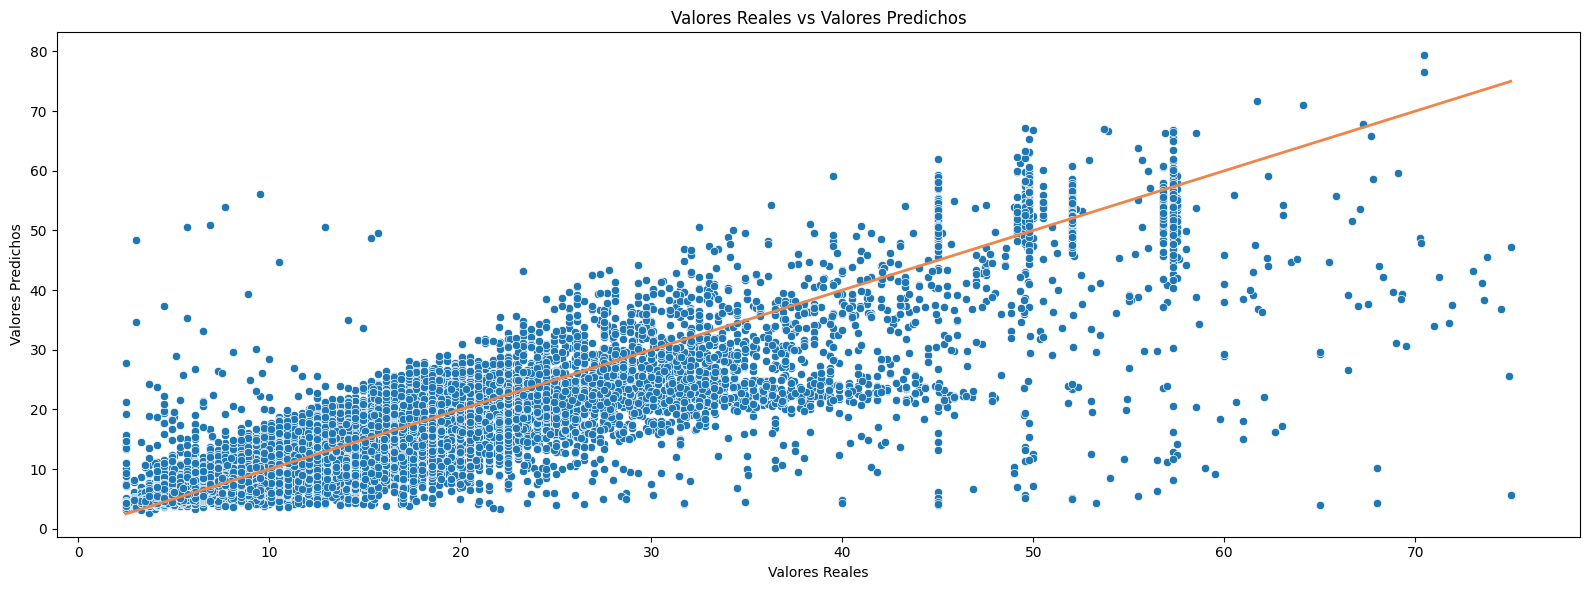

In [376]:
# Gráfico de valores reales vs predichos
plt.figure(figsize=(16, 6))

sns.scatterplot(x=y_test_original, y=y_test_pred_original)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Valores Predichos')

plt.tight_layout()
plt.show()

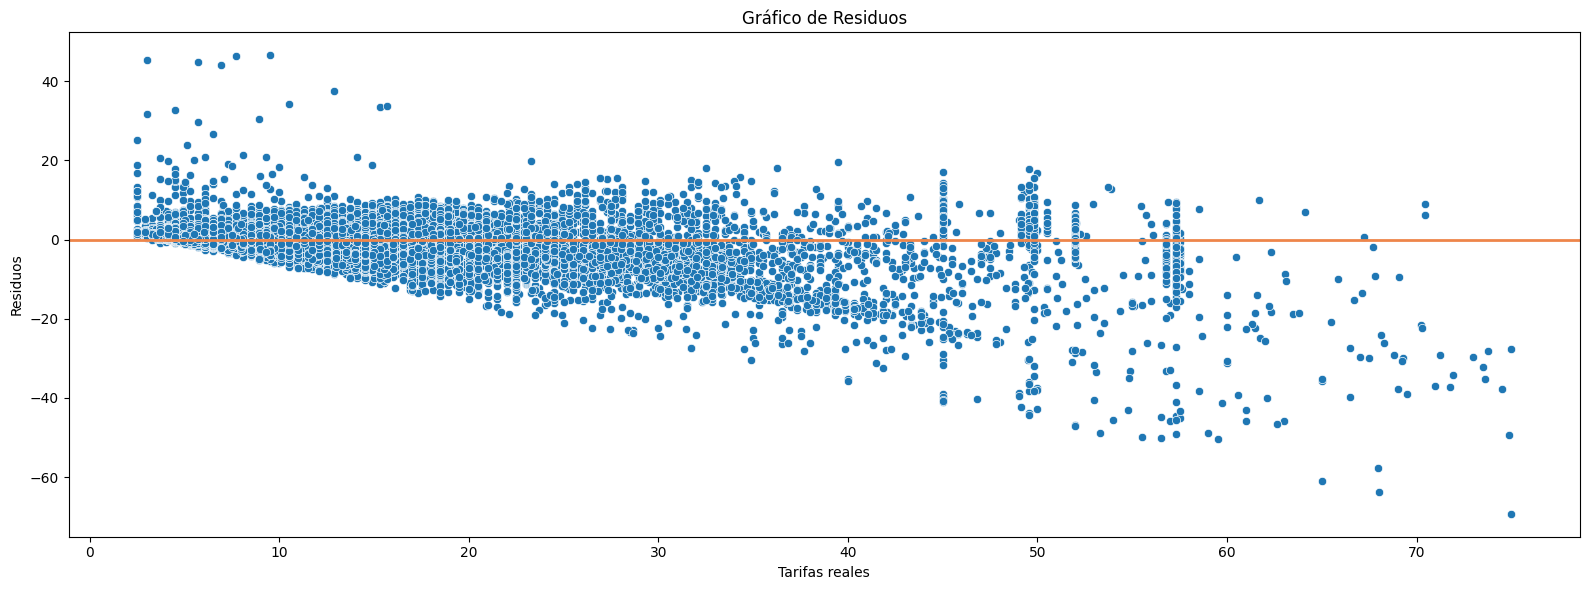

In [377]:
# Gráfico de residuos
plt.figure(figsize=(16, 6))

residuos =  y_test_pred_original - y_test_original

sns.scatterplot(x=y_test_original, y=residuos, alpha=1)
plt.axhline(0, color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Tarifas reales')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')

plt.tight_layout()
plt.show()

Observamos que el modelo tiene mayor dificultad para predecir tarifas más altas. Muestra signos de heterocedasticidad.

### Descenso por gradiente

In [378]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(16, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

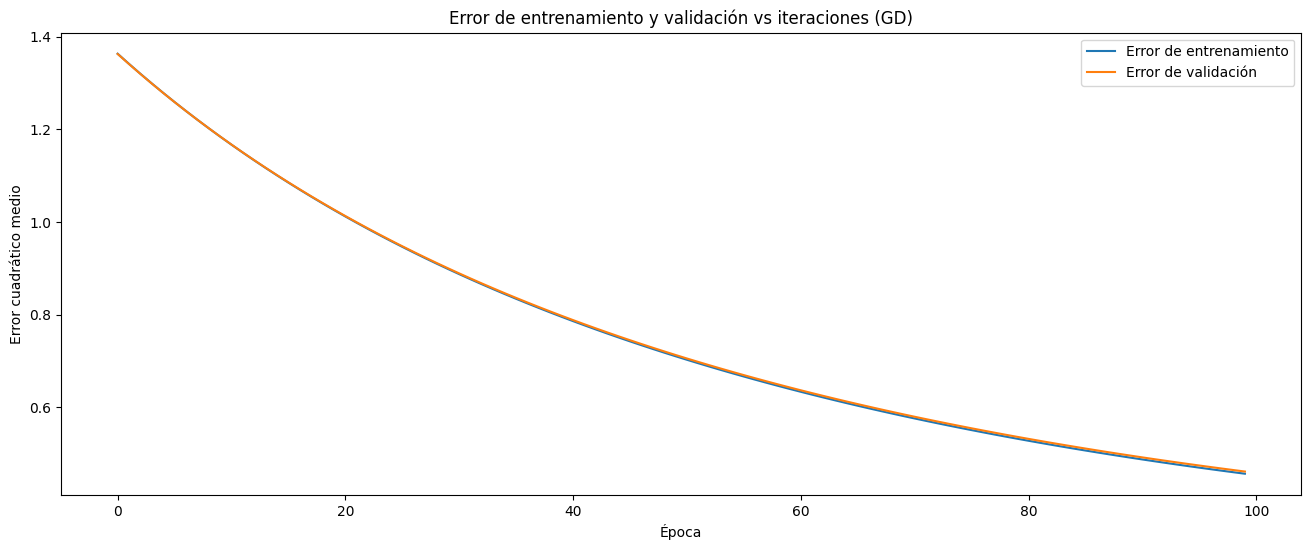

In [379]:
gd = gradient_descent(x_train.values, y_train.values.reshape(-1, 1), x_test.values, y_test.values.reshape(-1, 1), lr=0.01, epochs=100)

In [380]:
y_train_pred = np.matmul(np.hstack((np.ones((x_train.shape[0], 1)), x_train.values)), gd)
y_test_pred = np.matmul(np.hstack((np.ones((x_test.shape[0], 1)), x_test.values)), gd)

y_train_pred = y_train_pred.flatten()
y_test_pred = y_test_pred.flatten()

In [381]:
# Reescala las predicciones y los valores reales de tarifa (variable target)
y_test_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_test_pred_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test_pred), y_test_pred)))[:, 1]

In [382]:
# Estadisticas de desempeño
r2_train = r2_score(y_train, y_train_pred)
r2 = r2_score(y_test_original, y_test_pred_original)
mse = mean_squared_error(y_test_original, y_test_pred_original)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_original - y_test_pred_original))

rmse_modelos.append(rmse)
mae_modelos.append(mae)


print(f"Train R²: {r2_train:.4f}")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Train R²: 0.5520
R²: 0.5663
MSE: 37.8313
RMSE: 6.1507
MAE: 4.7654


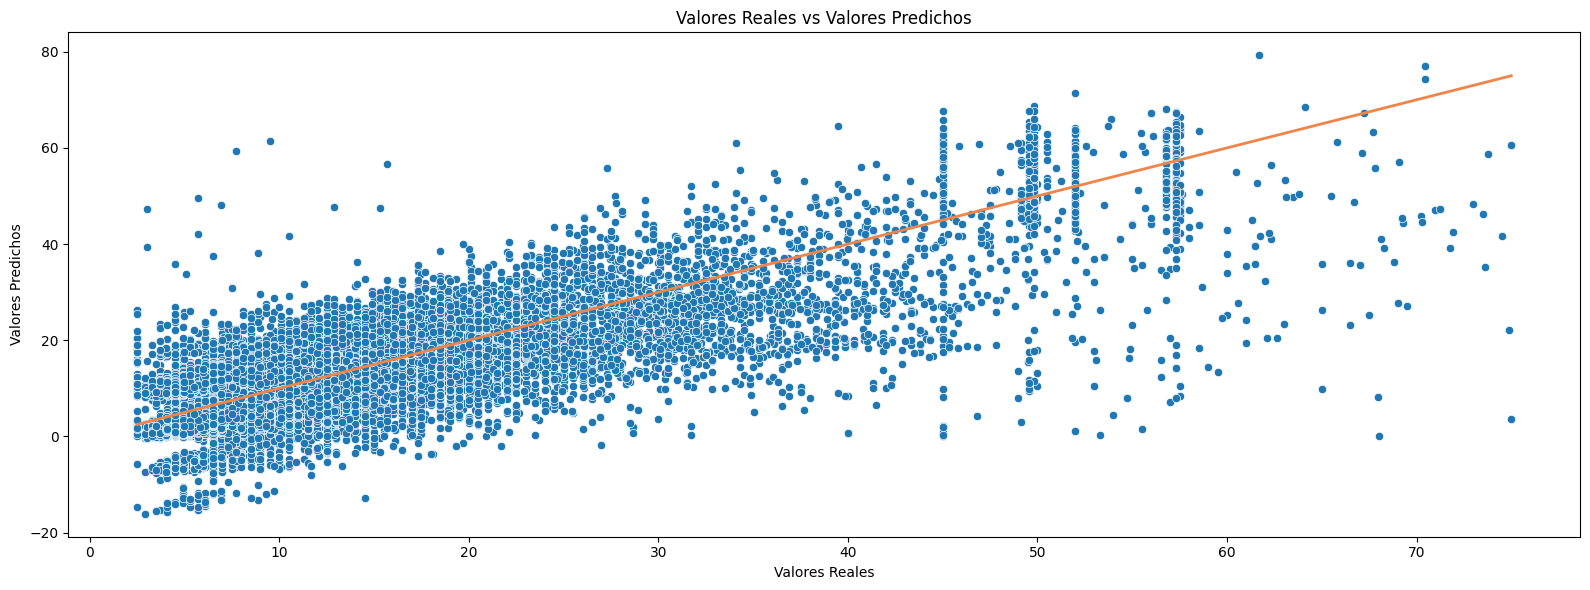

In [383]:
# Gráfico de valores reales vs predichos
plt.figure(figsize=(16, 6))

sns.scatterplot(x=y_test_original, y=y_test_pred_original)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Valores Predichos')

plt.tight_layout()
plt.show()

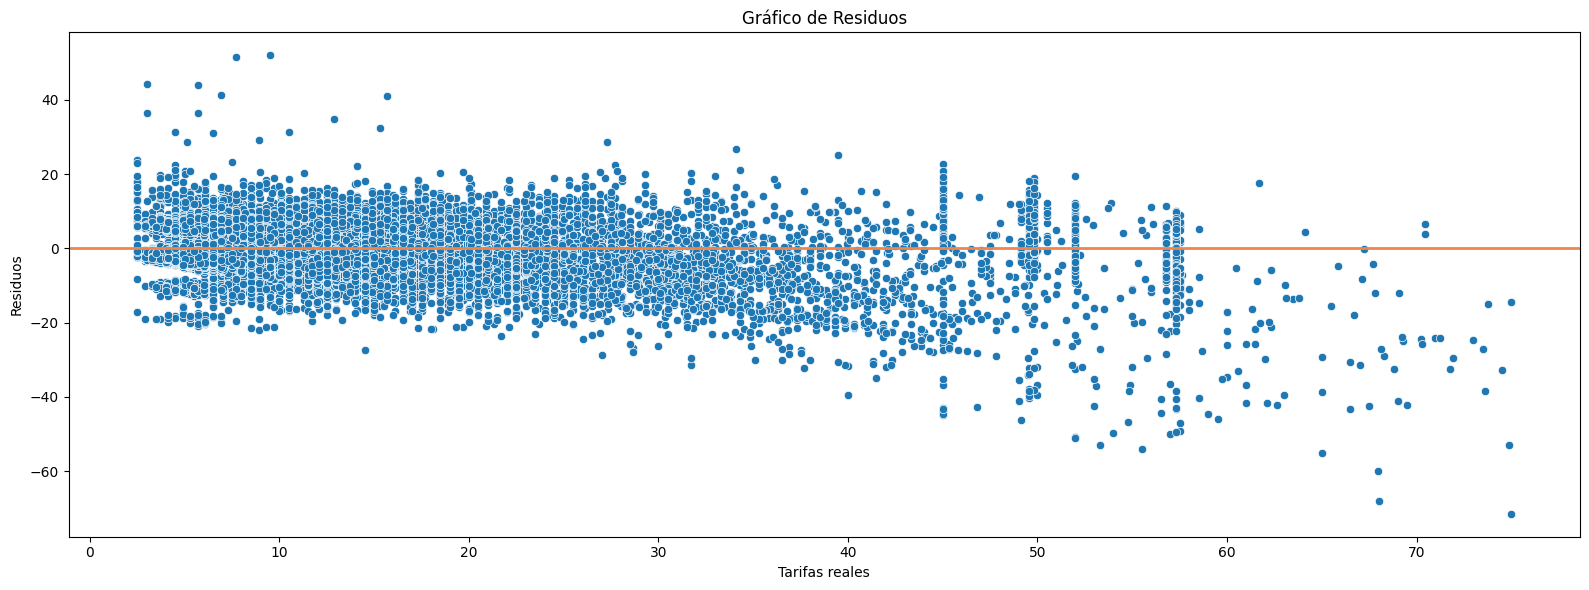

In [384]:
# Gráfico de residuos
plt.figure(figsize=(16, 6))

residuos =  y_test_pred_original - y_test_original

sns.scatterplot(x=y_test_original, y=residuos, alpha=1)
plt.axhline(0, color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Tarifas reales')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')

plt.tight_layout()
plt.show()

### Estocástico

In [385]:
sgd = SGDRegressor(max_iter=100, tol=1e-3, learning_rate='constant', eta0=0.01, random_state=1)

In [386]:
r2_train = cross_val_score(sgd, x_train, y_train, cv=5).mean()

sgd.fit(x_train, y_train)
y_test_pred = sgd.predict(x_test)

In [387]:
# Reescala las predicciones y los valores reales de tarifa (variable target)
y_test_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_test_pred_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test_pred), y_test_pred)))[:, 1]

In [388]:
# Estadísticas de desempeño
r2 = r2_score(y_test_original, y_test_pred_original)
mse = mean_squared_error(y_test_original, y_test_pred_original)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_original - y_test_pred_original))

rmse_modelos.append(rmse)
mae_modelos.append(mae)


print(f"Train R²: {r2_train:.4f}")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Train R²: 0.7947
R²: 0.7944
MSE: 17.9373
RMSE: 4.2352
MAE: 2.3608


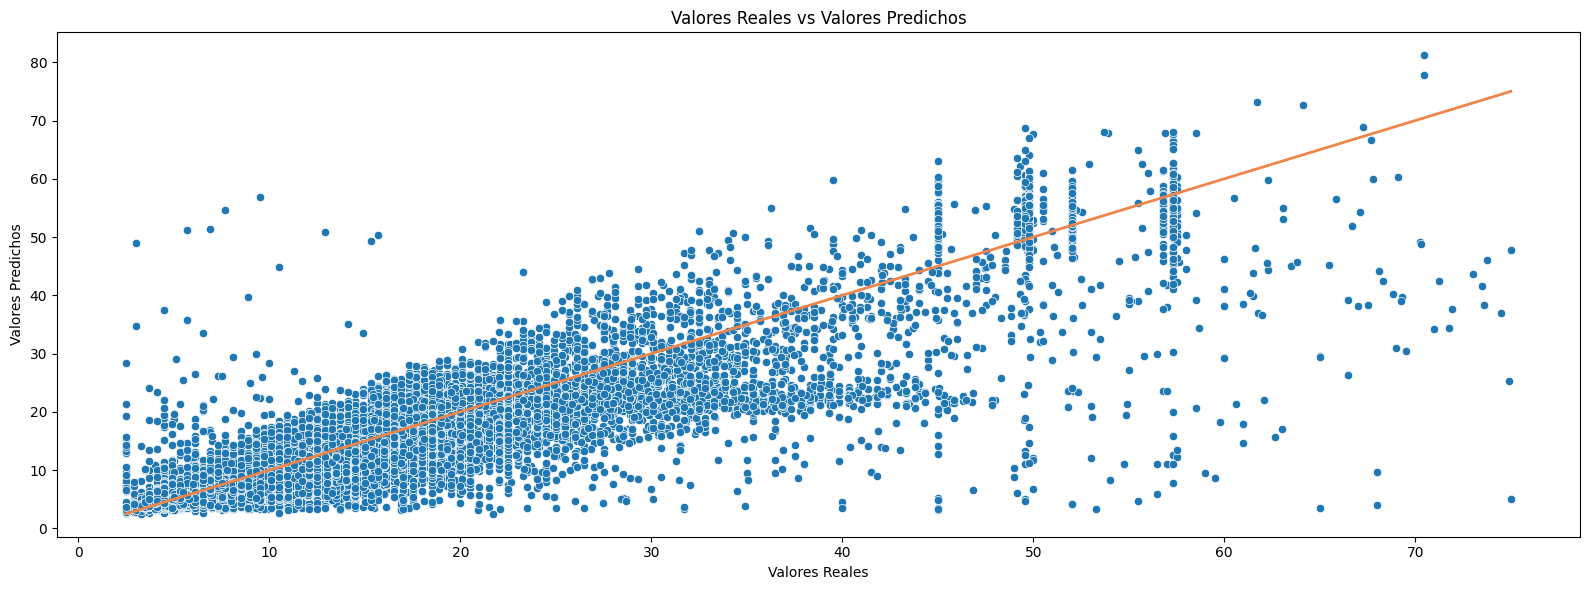

In [389]:
# Gráfico de valores reales vs predichos
plt.figure(figsize=(16, 6))

sns.scatterplot(x=y_test_original, y=y_test_pred_original)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Valores Predichos')

plt.tight_layout()
plt.show()

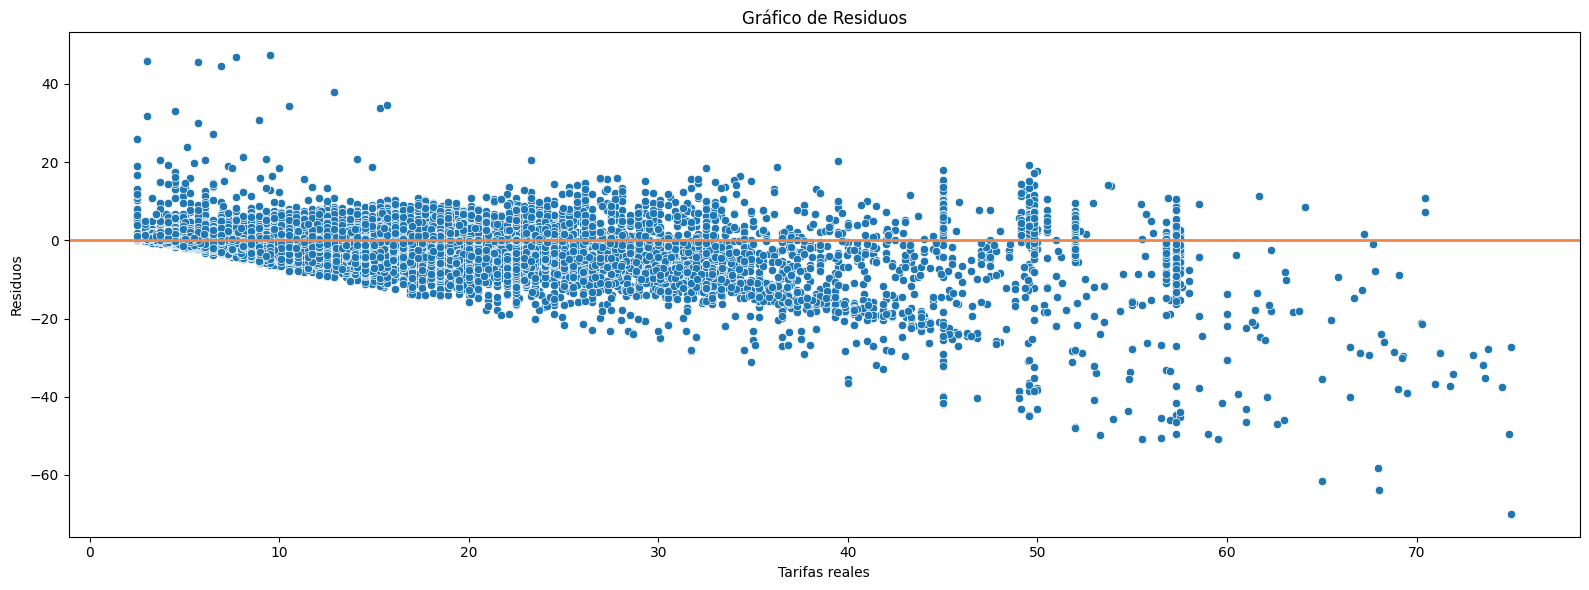

In [390]:
# Gráfico de residuos
plt.figure(figsize=(16, 6))

residuos =  y_test_pred_original - y_test_original

sns.scatterplot(x=y_test_original, y=residuos, alpha=1)
plt.axhline(0, color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Tarifas reales')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')

plt.tight_layout()
plt.show()

### Mini-batch

In [391]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(16, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

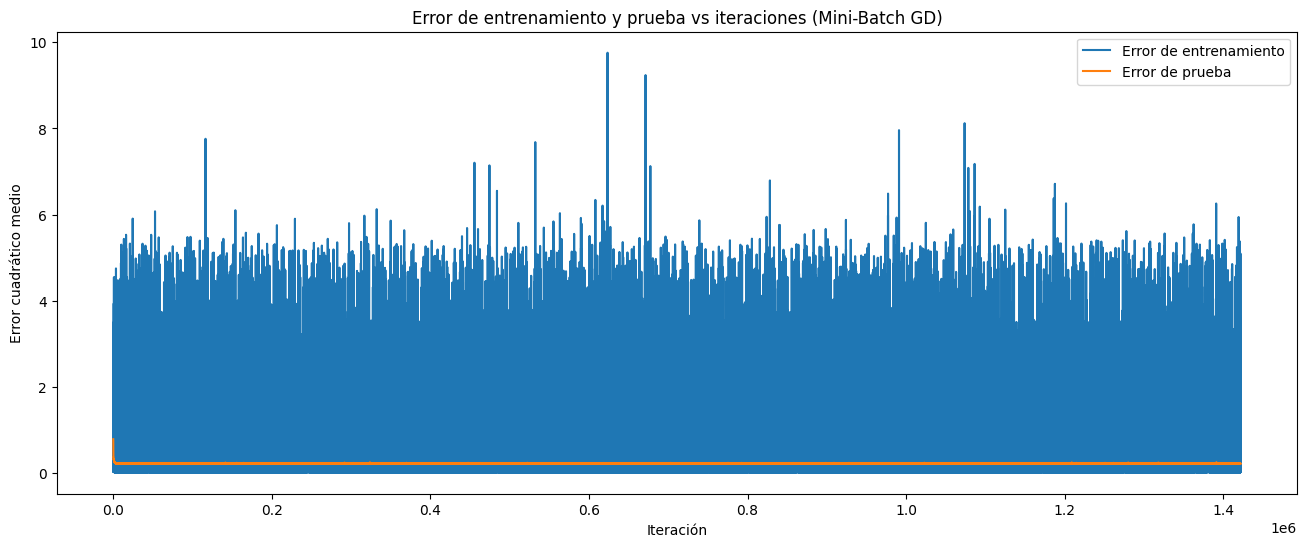

In [392]:
mbgd = mini_batch_gradient_descent(x_train.values, y_train.values.reshape(-1, 1), x_test.values, y_test.values.reshape(-1, 1), lr=0.01, epochs=100, batch_size=11)

In [393]:
y_train_pred = np.matmul(np.hstack((np.ones((x_train.shape[0], 1)), x_train)), mbgd)
y_train_pred = y_train_pred.flatten()

y_test_pred = np.matmul(np.hstack((np.ones((x_test.shape[0], 1)), x_test)), mbgd)
y_test_pred = y_test_pred.flatten()

In [394]:
# Reescala las predicciones y los valores reales de tarifa (variable target)
y_test_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_test_pred_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test_pred), y_test_pred)))[:, 1]

In [395]:
# Estadísticas de desempeño
r2_train = r2_score(y_train, y_train_pred)
r2 = r2_score(y_test_original, y_test_pred_original)
mse = mean_squared_error(y_test_original, y_test_pred_original)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_original - y_test_pred_original))

rmse_modelos.append(rmse)
mae_modelos.append(mae)


print(f"Train R²: {r2_train:.4f}")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Train R²: 0.7956
R²: 0.7972
MSE: 17.6883
RMSE: 4.2057
MAE: 2.4483


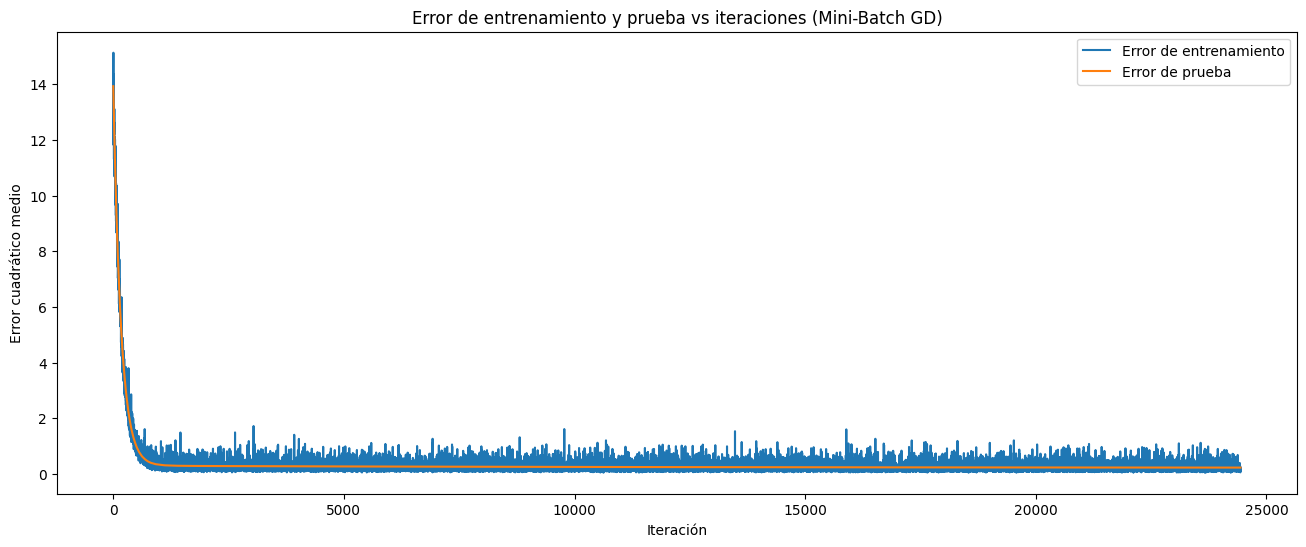

In [396]:
mbgd = mini_batch_gradient_descent(x_train.values, y_train.values.reshape(-1, 1), x_test.values, y_test.values.reshape(-1, 1), lr=0.001, epochs=10, batch_size=64)

In [397]:
y_train_pred = np.matmul(np.hstack((np.ones((x_train.shape[0], 1)), x_train)), mbgd)
y_train_pred = y_train_pred.flatten()

y_test_pred = np.matmul(np.hstack((np.ones((x_test.shape[0], 1)), x_test)), mbgd)
y_test_pred = y_test_pred.flatten()

In [398]:
# Reescala las predicciones y los valores reales de tarifa (variable target)
y_test_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_test_pred_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test_pred), y_test_pred)))[:, 1]

In [399]:
# Estadísticas de desempeño
r2_train = r2_score(y_train, y_train_pred)
r2 = r2_score(y_test_original, y_test_pred_original)
mse = mean_squared_error(y_test_original, y_test_pred_original)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_original - y_test_pred_original))

rmse_modelos.append(rmse)
mae_modelos.append(mae)


print(f"Train R²: {r2_train:.4f}")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Train R²: 0.7881
R²: 0.7889
MSE: 18.4173
RMSE: 4.2915
MAE: 2.4896


Con Learning Rate = 0.1 y batch_size = 11 la gráfica del error de entrenamiento fluctúa considerablemente, aunque obtenemos buenas métricas, visualmente no se puede distinguir una convergencia.

En cambio, con un Learning Rate = 0.001 y batch_size = 64, el error disminuye de manera más suave y estable, indicando que el learning rate más bajo permite ajustes más finos, reduciendo la inestabilidad.

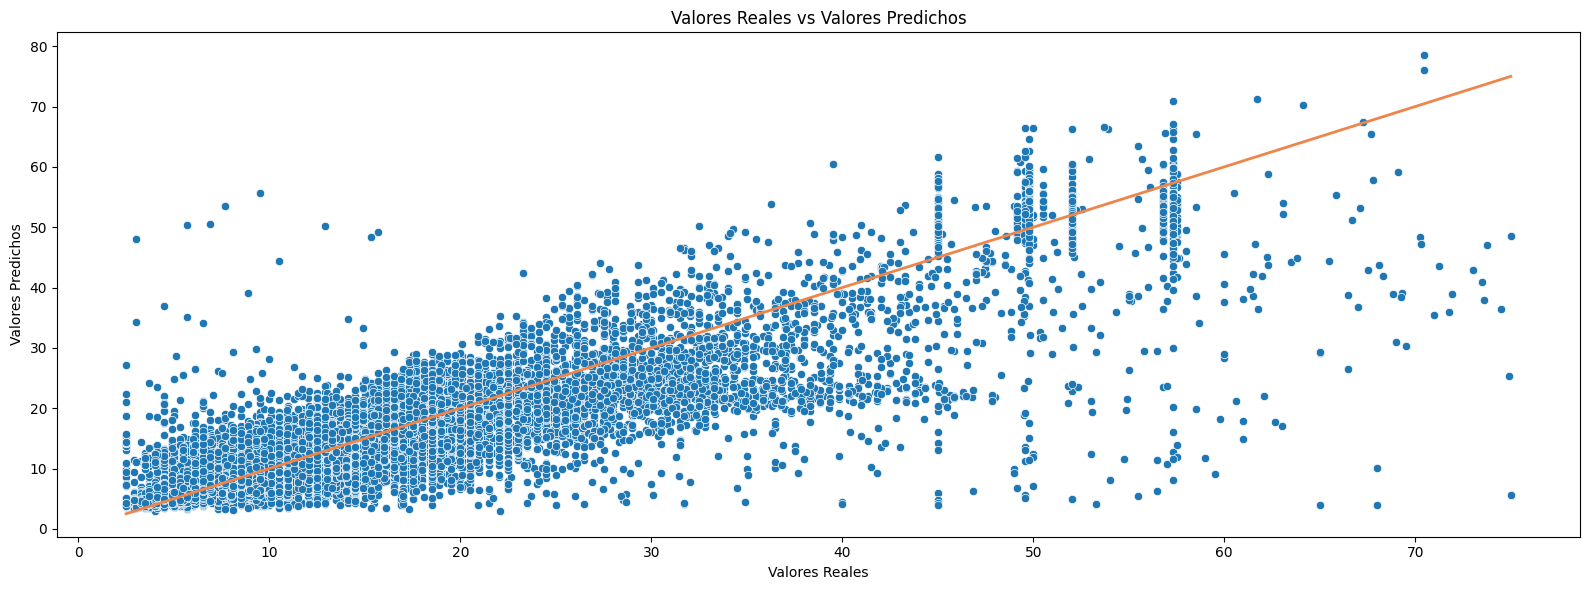

In [400]:
# Gráfico de valores reales vs predichos
plt.figure(figsize=(16, 6))

sns.scatterplot(x=y_test_original, y=y_test_pred_original)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Valores Predichos')

plt.tight_layout()
plt.show()

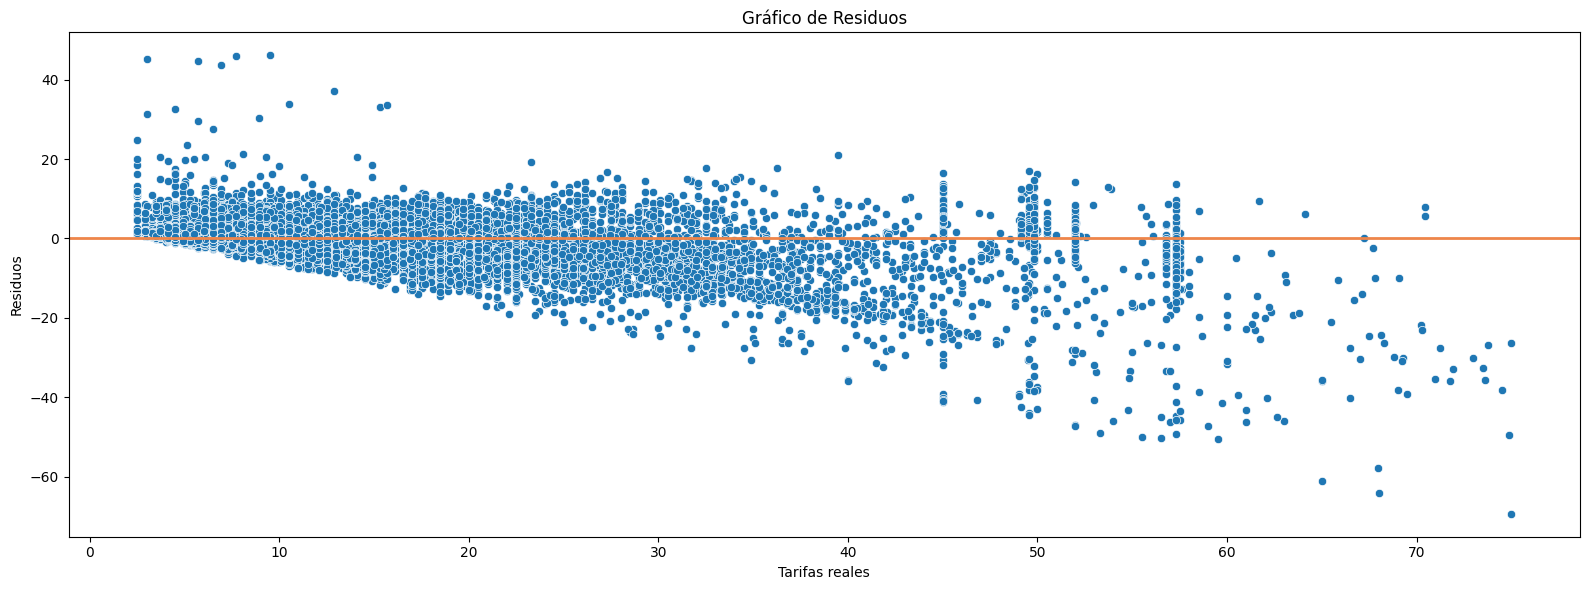

In [401]:
# Gráfico de residuos
plt.figure(figsize=(16, 6))

residuos =  y_test_pred_original - y_test_original

sns.scatterplot(x=y_test_original, y=residuos, alpha=1)
plt.axhline(0, color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Tarifas reales')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')

plt.tight_layout()
plt.show()

## Regularización

### Ridge

In [402]:
ridge = RidgeCV(
    alphas = np.logspace(-3, 8, 200),
    fit_intercept = True,
    store_cv_results = True
)

ridge.fit(x_train, y_train)

RidgeCV(alphas=array([1.00000000e-03, 1.13573336e-03, 1.28989026e-03, 1.46497140e-03,
       1.66381689e-03, 1.88965234e-03, 2.14614120e-03, 2.43744415e-03,
       2.76828663e-03, 3.14403547e-03, 3.57078596e-03, 4.05546074e-03,
       4.60592204e-03, 5.23109931e-03, 5.94113398e-03, 6.74754405e-03,
       7.66341087e-03, 8.70359136e-03, 9.88495905e-03, 1.12266777e-02,
       1.27505124e-02, 1.44811823e-0...
       5.35356668e+06, 6.08022426e+06, 6.90551352e+06, 7.84282206e+06,
       8.90735464e+06, 1.01163798e+07, 1.14895100e+07, 1.30490198e+07,
       1.48202071e+07, 1.68318035e+07, 1.91164408e+07, 2.17111795e+07,
       2.46581108e+07, 2.80050389e+07, 3.18062569e+07, 3.61234270e+07,
       4.10265811e+07, 4.65952567e+07, 5.29197874e+07, 6.01027678e+07,
       6.82607183e+07, 7.75259749e+07, 8.80488358e+07, 1.00000000e+08]),
        store_cv_results=True)

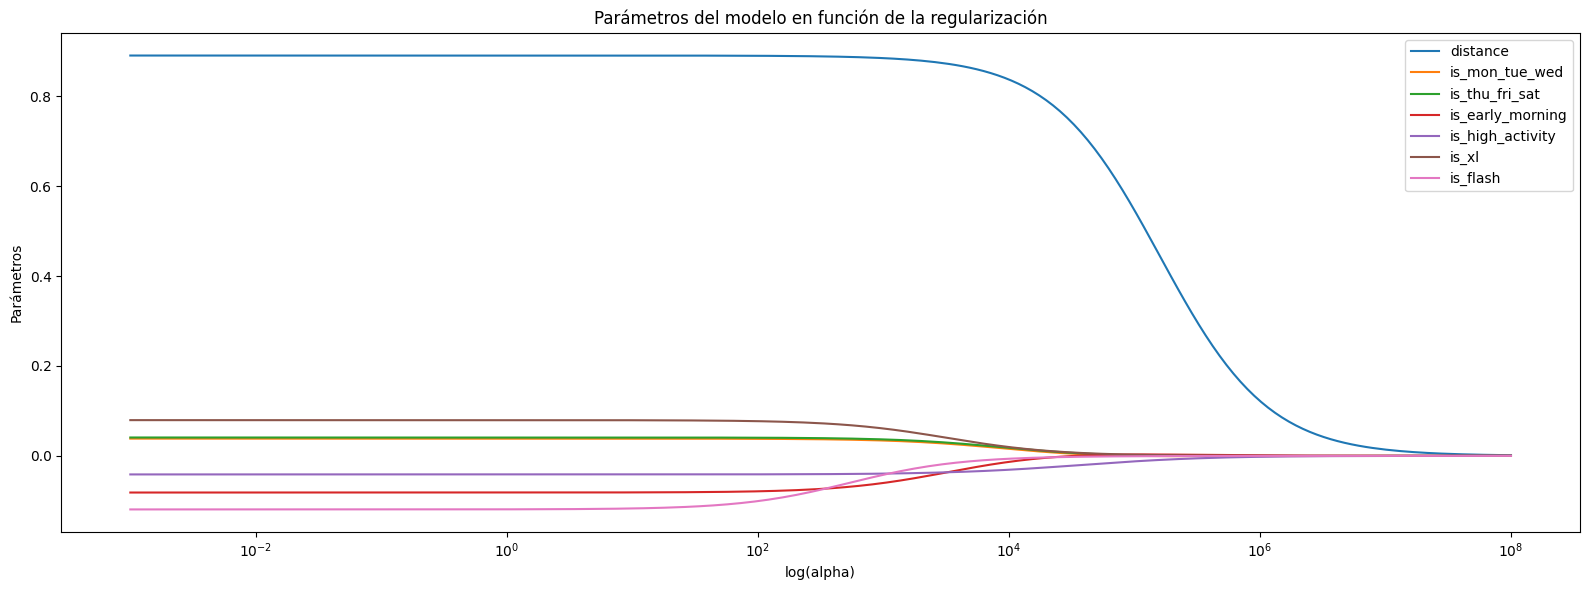

In [403]:
alphas = ridge.alphas
coefs = []

for alpha in alphas:
    ridge_aux = Ridge(alpha=alpha)
    ridge_aux.fit(x_train, y_train)
    coefs.append(ridge_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(alphas, coefs, label=x_train.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización')

plt.legend()
plt.tight_layout()
plt.show()

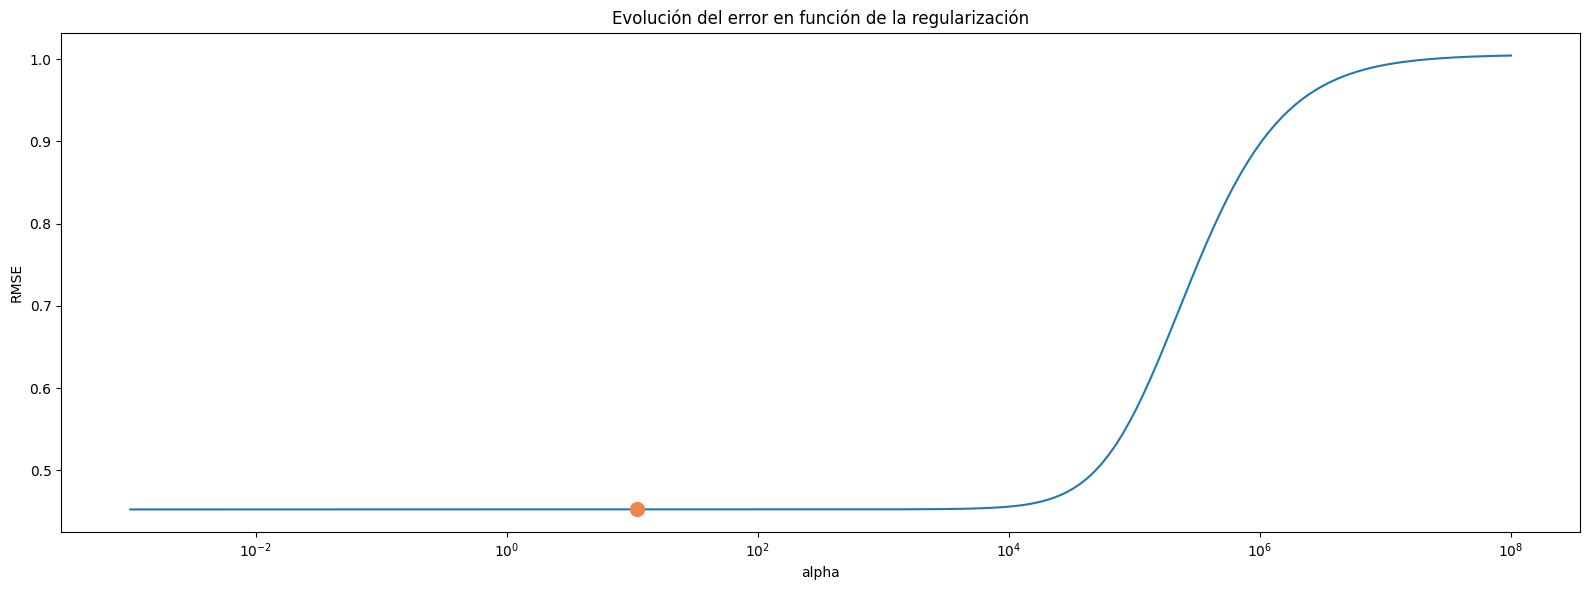

In [404]:
mse_cv = ridge.cv_results_.reshape((-1, 200)).mean(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Calcula R2
r2_train = 1 - np.min(mse_cv) / np.var(y_train)

# Se identifica el mejor
min_rmse     = np.min(rmse_cv)
optimo       = ridge.alphas[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(ridge.alphas, rmse_cv)
ax.set_xscale('log')
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')

ax.plot(optimo, min_rmse, marker='o', markersize=10, color=sns.color_palette("muted")[1])

plt.tight_layout()
plt.show()

In [405]:
# Métrica de train cross-validation
print(f"El valor óptimo de alpha es: {optimo:.2f} con un RMSE de {min_rmse:.2f} y un R² de {r2_train:.4f}")

El valor óptimo de alpha es: 10.84 con un RMSE de 0.45 y un R² de 0.7974


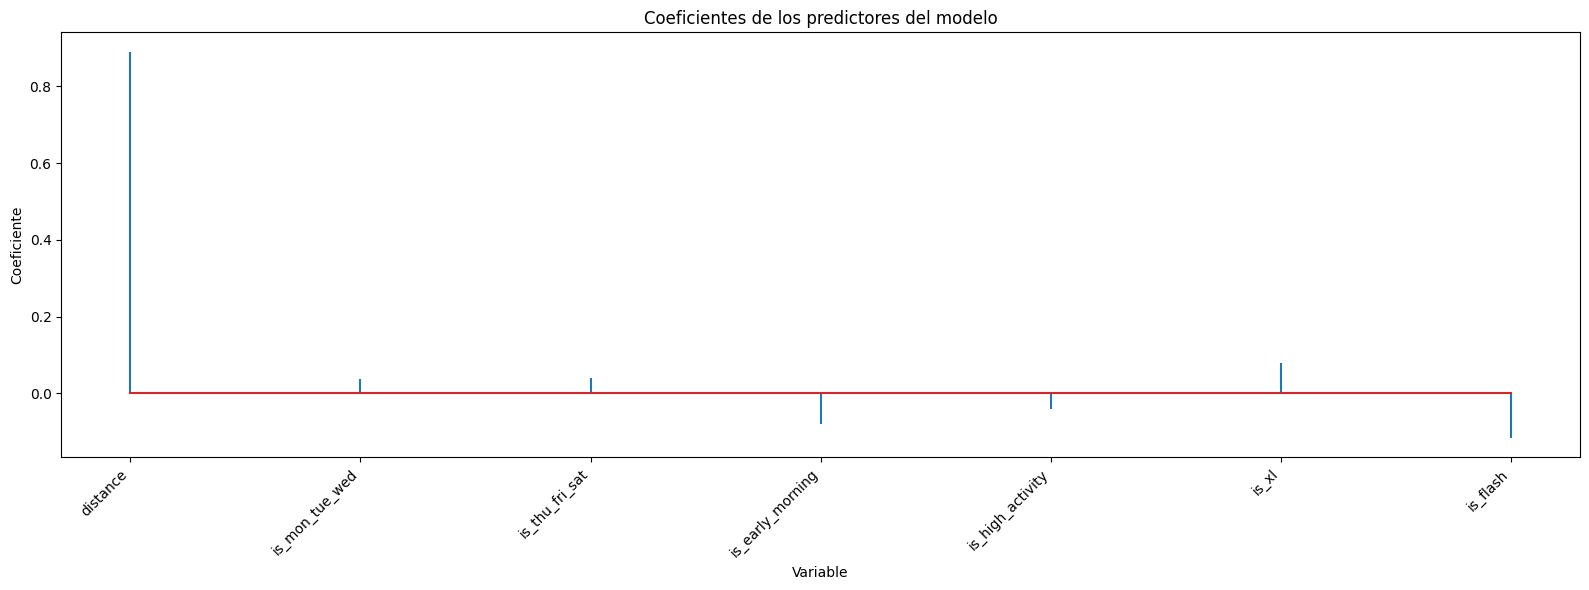

In [406]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame({'predictor': x_train.columns,'coef': ridge.coef_.flatten()})

fig, ax = plt.subplots(figsize=(16,6))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=45, ha='right', size=10)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficiente')
ax.set_title('Coeficientes de los predictores del modelo')

plt.tight_layout()
plt.show()

In [407]:
y_test_pred = ridge.predict(x_test)

# Reescala las predicciones y los valores reales de tarifa (variable target)
y_test_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_test_pred_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test_pred), y_test_pred)))[:, 1]

r2 = r2_score(y_test_original, y_test_pred_original)
mse = mean_squared_error(y_test_original, y_test_pred_original)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_original - y_test_pred_original))

rmse_modelos.append(rmse)
mae_modelos.append(mae)


print(f"Train R²: {r2_train:.4f}")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Train R²: 0.7974
R²: 0.7985
MSE: 17.5765
RMSE: 4.1924
MAE: 2.4171


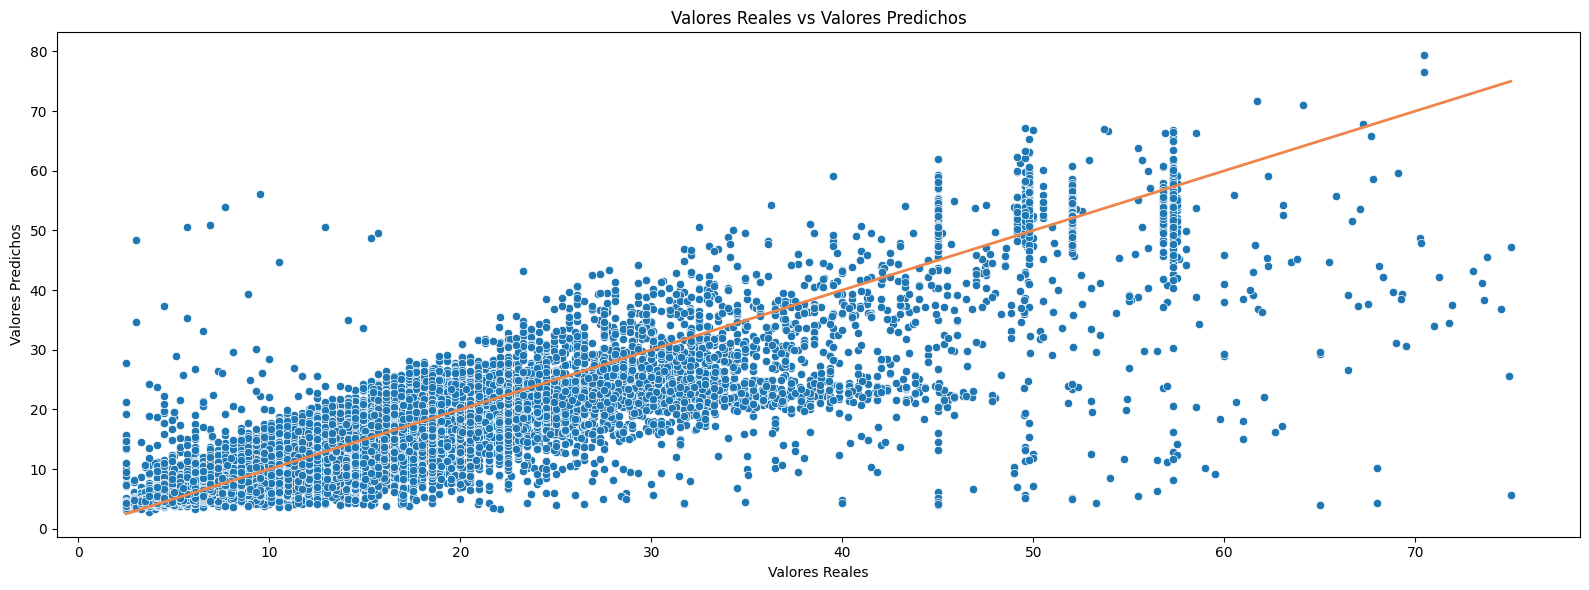

In [408]:
# Gráfico de valores reales vs predichos
plt.figure(figsize=(16, 6))

sns.scatterplot(x=y_test_original, y=y_test_pred_original)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Valores Predichos')

plt.tight_layout()
plt.show()

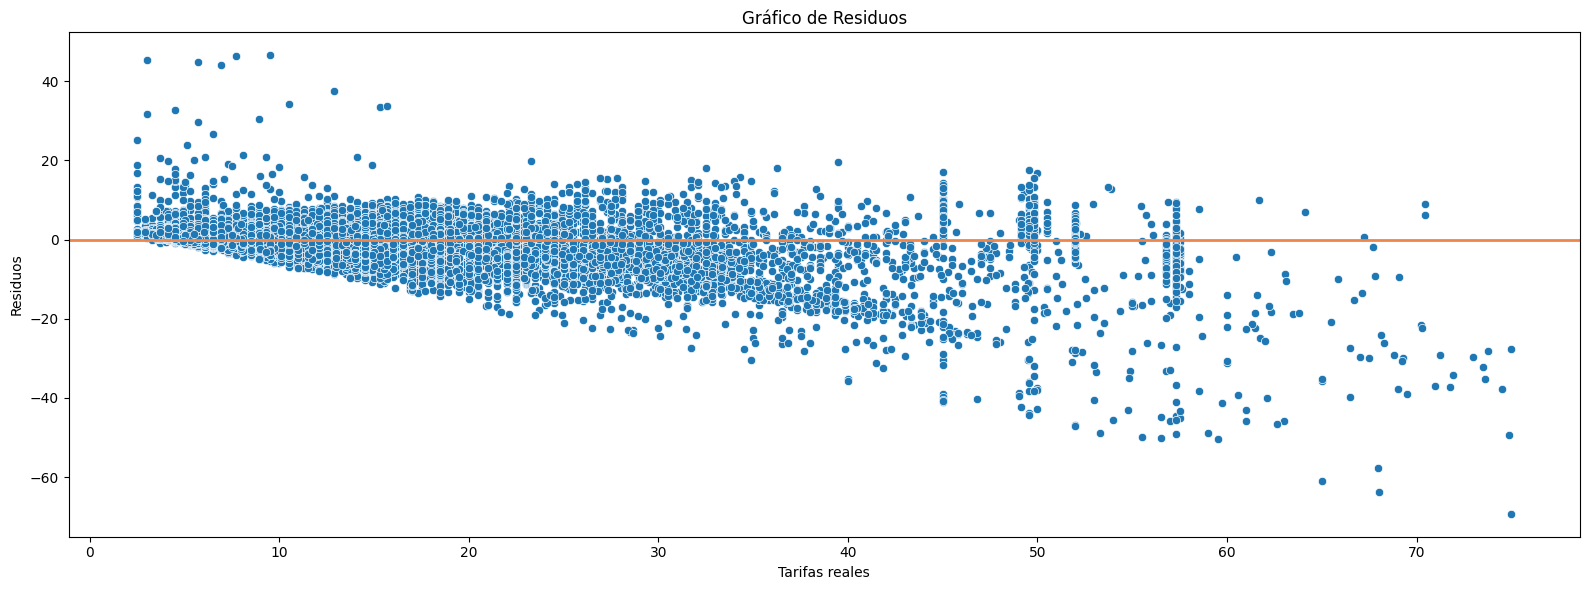

In [409]:
# Gráfico de residuos
plt.figure(figsize=(16, 6))

residuos =  y_test_pred_original - y_test_original

sns.scatterplot(x=y_test_original, y=residuos, alpha=1)
plt.axhline(0, color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Tarifas reales')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')

plt.tight_layout()
plt.show()

### Lasso

In [410]:
lasso = LassoCV(
    alphas=np.logspace(-5, 1, 500),
    cv=10
)

lasso.fit(x_train, y_train)


LassoCV(alphas=array([1.00000000e-05, 1.02807322e-05, 1.05693455e-05, 1.08660611e-05,
       1.11711065e-05, 1.14847155e-05, 1.18071285e-05, 1.21385926e-05,
       1.24793621e-05, 1.28296980e-05, 1.31898690e-05, 1.35601511e-05,
       1.39408283e-05, 1.43321923e-05, 1.47345431e-05, 1.51481892e-05,
       1.55734477e-05, 1.60106446e-05, 1.64601150e-05, 1.69222035e-05,
       1.73972643e-05, 1.78856616e-0...
       5.28989308e+00, 5.43839743e+00, 5.59107078e+00, 5.74803016e+00,
       5.90939590e+00, 6.07529169e+00, 6.24584471e+00, 6.42118571e+00,
       6.60144909e+00, 6.78677305e+00, 6.97729965e+00, 7.17317494e+00,
       7.37454909e+00, 7.58157646e+00, 7.79441575e+00, 8.01323013e+00,
       8.23818733e+00, 8.46945981e+00, 8.70722485e+00, 8.95166472e+00,
       9.20296681e+00, 9.46132376e+00, 9.72693362e+00, 1.00000000e+01]),
        cv=10)

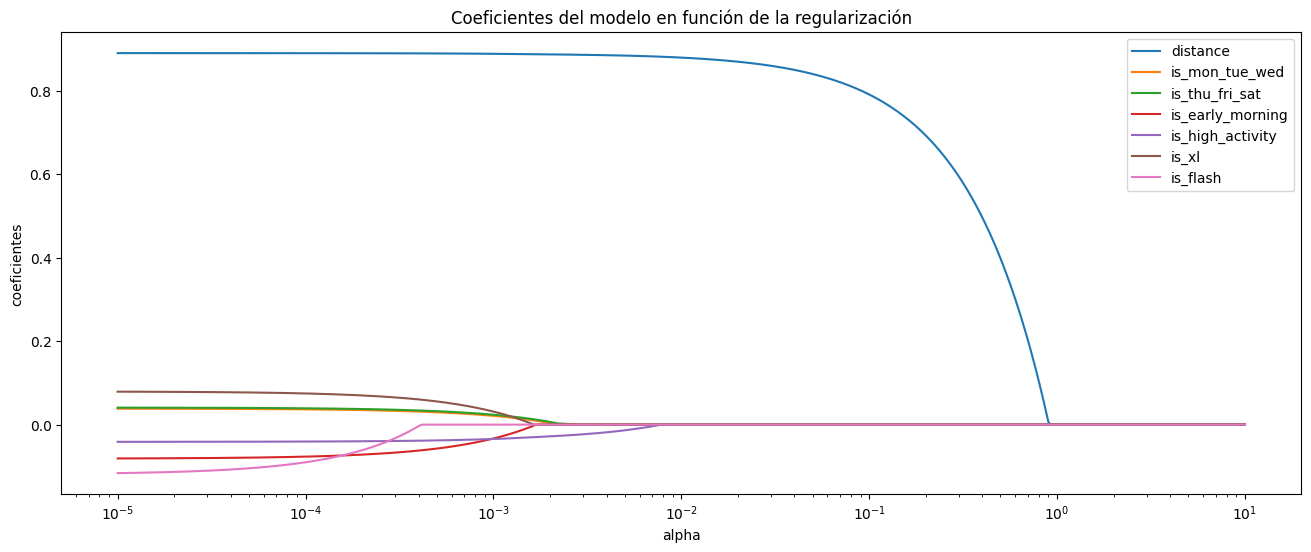

In [411]:
alphas = lasso.alphas_
coefs = []

for alpha in alphas:
    modelo_aux = Lasso(alpha=alpha)
    modelo_aux.fit(x_train, y_train)
    coefs.append(modelo_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(alphas, coefs, label=x_train.columns)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

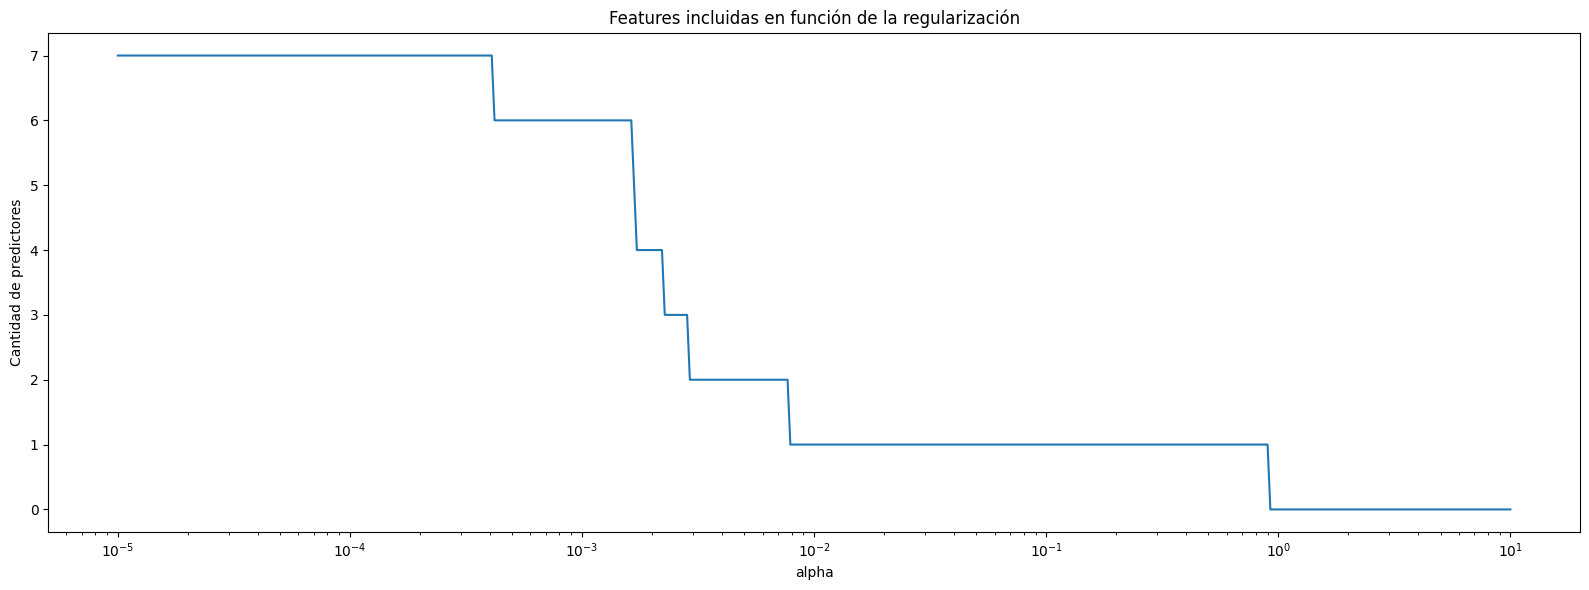

In [412]:
# Número de features incluidas (parámetros !=0) en función de alpha
alphas = lasso.alphas_
n_predictores = []

for alpha in alphas:
    modelo_aux = Lasso(alpha=alpha)
    modelo_aux.fit(x_train, y_train)
    coef_no_cero = np.sum(modelo_aux.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('Cantidad de predictores')
ax.set_title('Features incluidas en función de la regularización')

plt.tight_layout()
plt.show()

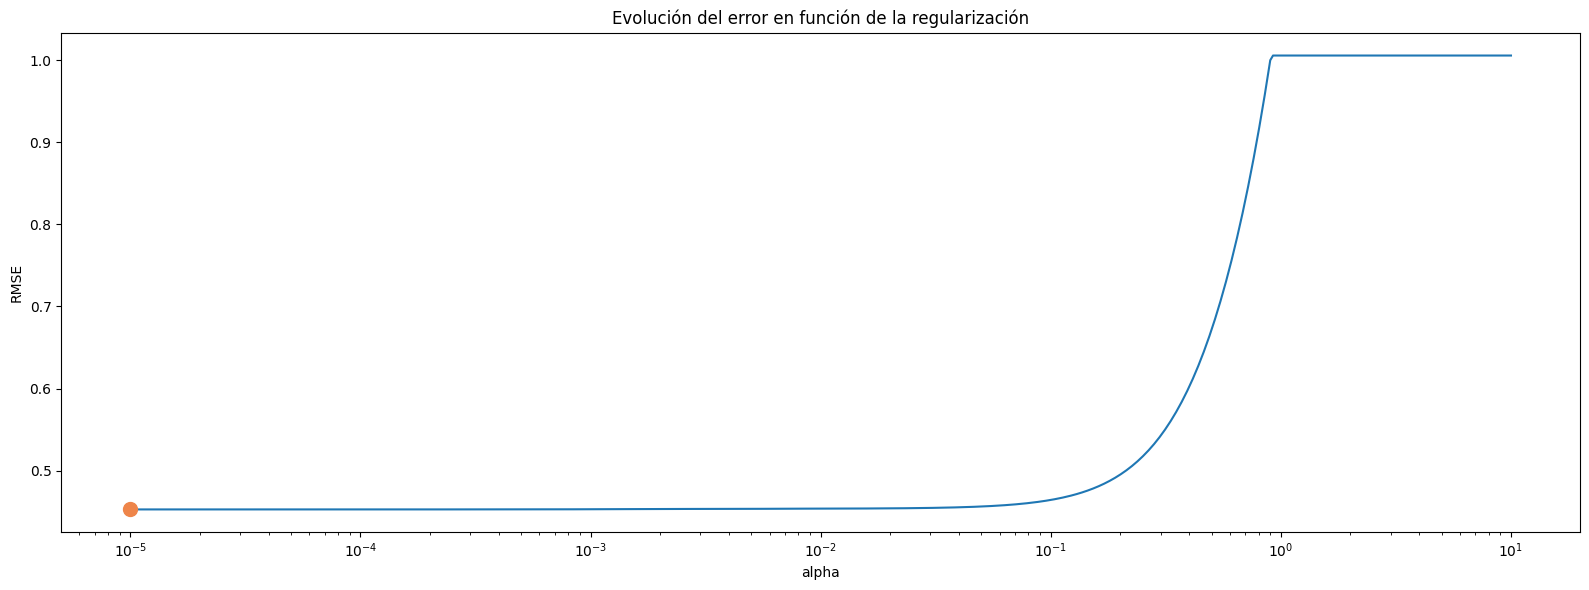

In [413]:
# Evolución del error de validación cruzada en función de alpha

# modelo.mse_path almacena el MSE de CV para cada valor de alpha.

mse_cv = lasso.mse_path_.mean(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Calcula R2
r2_train = 1 - np.min(mse_cv) / np.var(y_train)

# Se identifica el mejor
min_rmse     = np.min(rmse_cv)
optimo       = lasso.alphas_[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(lasso.alphas_, rmse_cv)
ax.set_xscale('log')
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')

ax.plot(optimo, min_rmse, marker='o', markersize=10, color=sns.color_palette("muted")[1])

plt.tight_layout()
plt.show()

In [414]:
# Métrica de train cross-validation
print(f"El valor óptimo de alpha es: {optimo:.2f} con un RMSE de {min_rmse:.2f} y un R² de {r2_train:.4f}")

El valor óptimo de alpha es: 0.00 con un RMSE de 0.45 y un R² de 0.7974


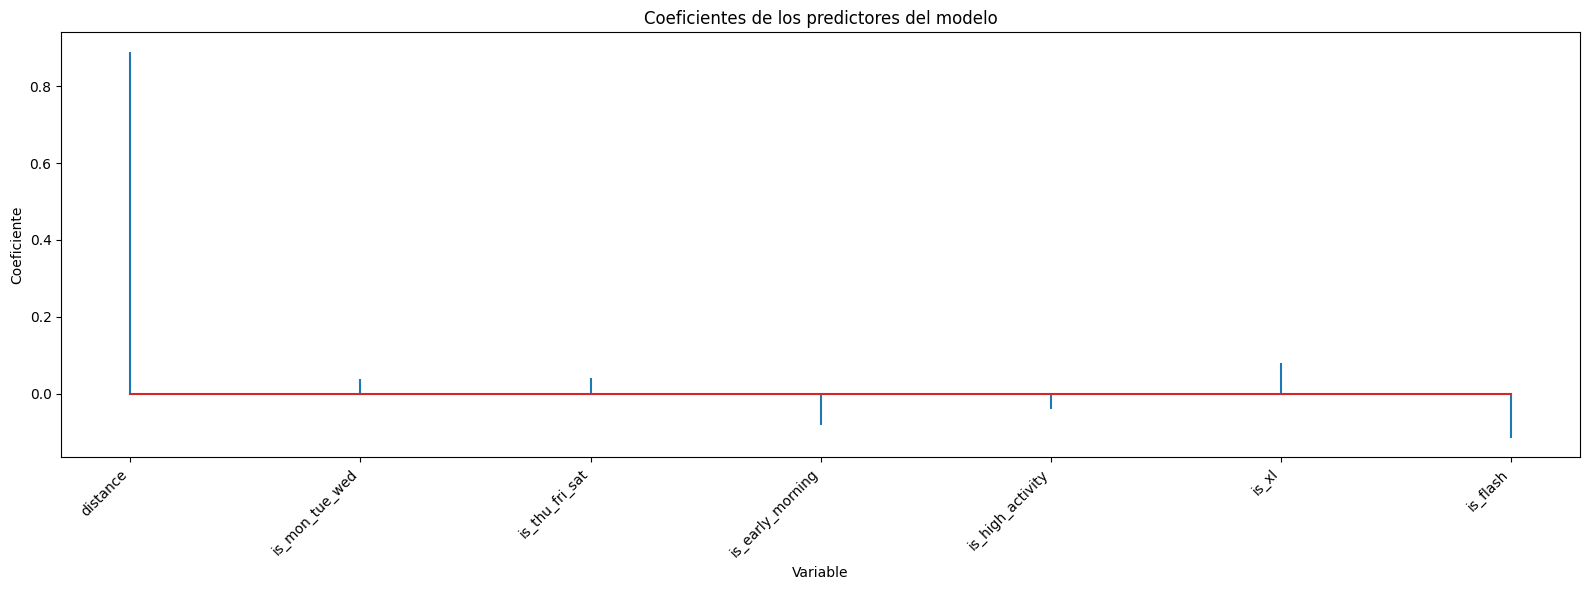

In [415]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame({'predictor': x_train.columns,'coef': lasso.coef_.flatten()})

fig, ax = plt.subplots(figsize=(16,6))

ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=45, ha='right', size=10)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficiente')
ax.set_title('Coeficientes de los predictores del modelo')

plt.tight_layout()
plt.show()

In [416]:
y_test_pred = lasso.predict(x_test)

# Reescala las predicciones y los valores reales de tarifa (variable target)
y_test_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_test_pred_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test_pred), y_test_pred)))[:, 1]

# Estadisticas de desempeño
r2 = r2_score(y_test_original, y_test_pred_original)
mse = mean_squared_error(y_test_original, y_test_pred_original)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_original - y_test_pred_original))

rmse_modelos.append(rmse)
mae_modelos.append(mae)


print(f"Train R²: {r2_train:.4f}")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Train R²: 0.7974
R²: 0.7985
MSE: 17.5765
RMSE: 4.1924
MAE: 2.4170


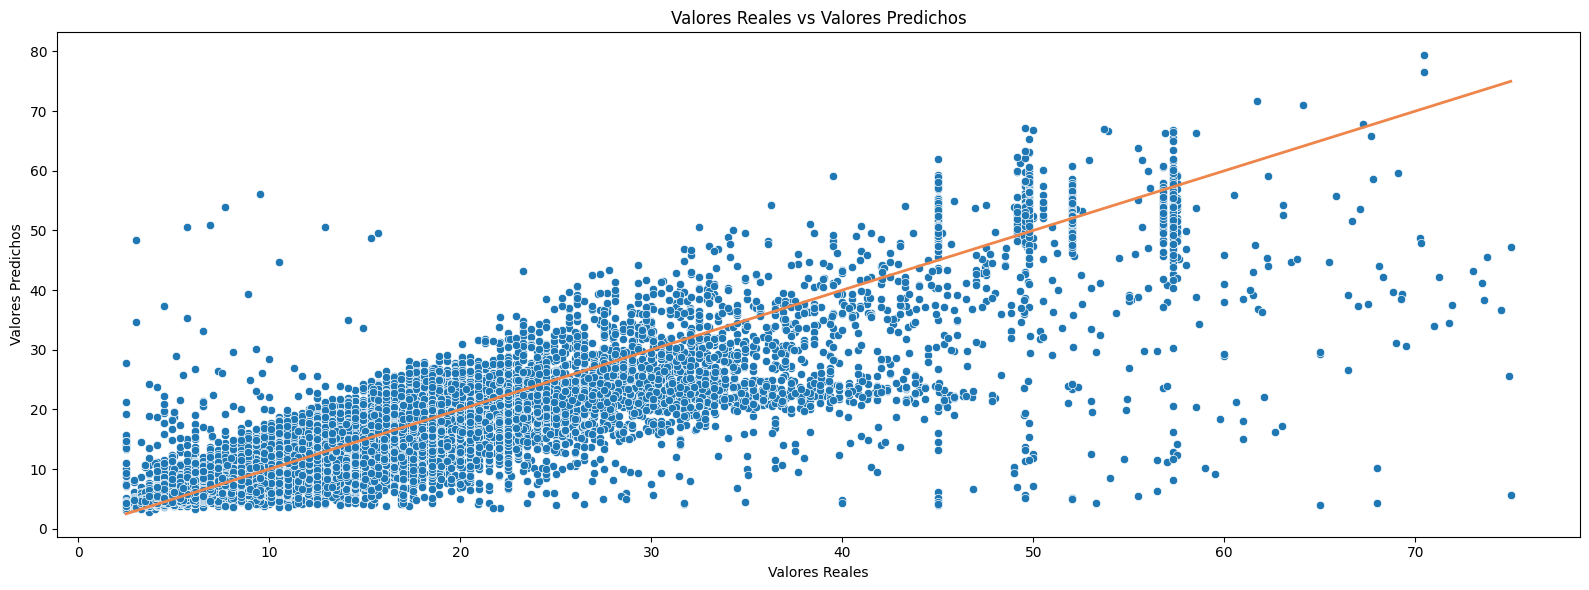

In [417]:
# Gráfico de valores reales vs predichos
plt.figure(figsize=(16, 6))

sns.scatterplot(x=y_test_original, y=y_test_pred_original)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Valores Predichos')

plt.tight_layout()
plt.show()

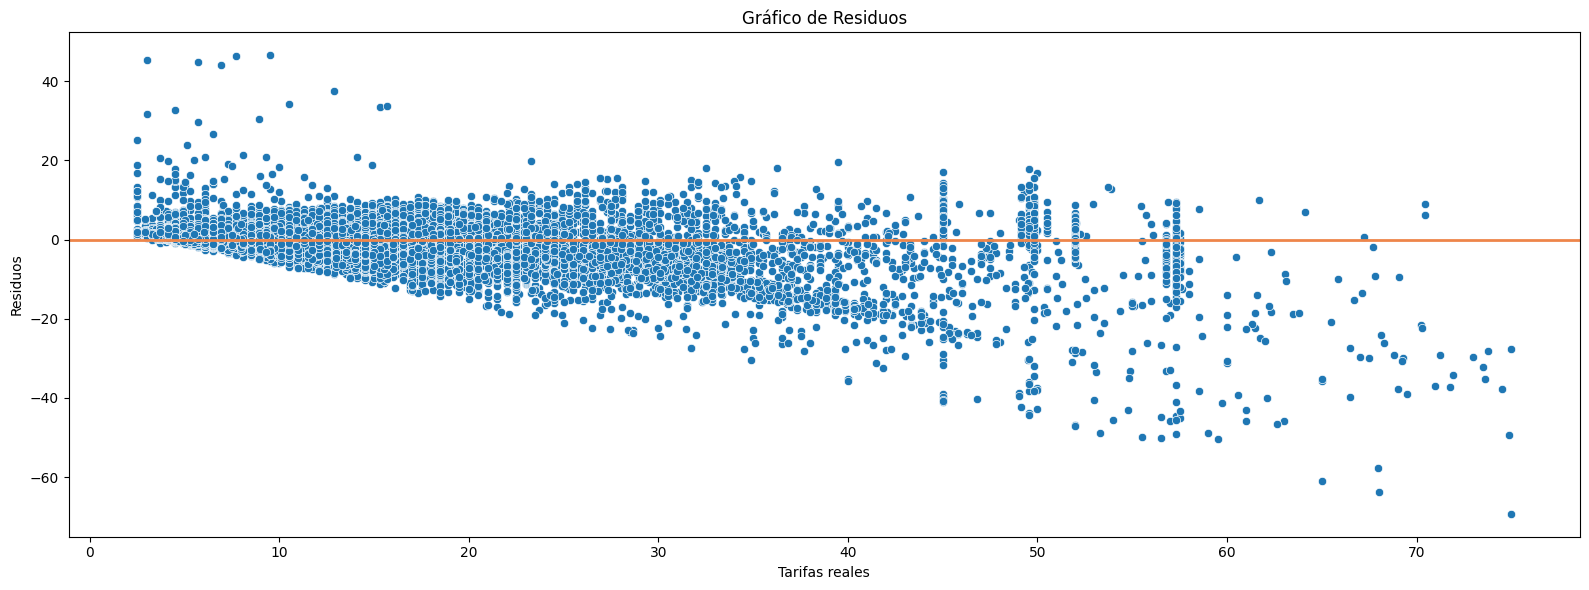

In [418]:
# Gráfico de residuos
plt.figure(figsize=(16, 6))

residuos =  y_test_pred_original - y_test_original

sns.scatterplot(x=y_test_original, y=residuos, alpha=1)
plt.axhline(0, color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Tarifas reales')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')

plt.tight_layout()
plt.show()

### Elastic Net

In [419]:
en = ElasticNetCV(
    l1_ratio        = [0.2, 0.4, 0.5, 0.6, 0.8],
    alphas          = np.logspace(-3, 6, 200),
    cv              = 10
)

en.fit(x_train, y_train)

ElasticNetCV(alphas=array([1.00000000e-03, 1.10975250e-03, 1.23155060e-03, 1.36671636e-03,
       1.51671689e-03, 1.68318035e-03, 1.86791360e-03, 2.07292178e-03,
       2.30043012e-03, 2.55290807e-03, 2.83309610e-03, 3.14403547e-03,
       3.48910121e-03, 3.87203878e-03, 4.29700470e-03, 4.76861170e-03,
       5.29197874e-03, 5.87278661e-03, 6.51733960e-03, 7.23263390e-03,
       8.02643352e-03, 8.907354...
       9.11588830e+04, 1.01163798e+05, 1.12266777e+05, 1.24588336e+05,
       1.38262217e+05, 1.53436841e+05, 1.70276917e+05, 1.88965234e+05,
       2.09704640e+05, 2.32720248e+05, 2.58261876e+05, 2.86606762e+05,
       3.18062569e+05, 3.52970730e+05, 3.91710149e+05, 4.34701316e+05,
       4.82410870e+05, 5.35356668e+05, 5.94113398e+05, 6.59318827e+05,
       7.31680714e+05, 8.11984499e+05, 9.01101825e+05, 1.00000000e+06]),
             cv=10, l1_ratio=[0.2, 0.4, 0.5, 0.6, 0.8])

In [420]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = en.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [en.l1_ratio, en.alphas_],
                                    names     = ['l1_ratio', 'en.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

l1_ratio      en.alphas_    mse_cv   rmse_cv
199       0.2        0.001000  0.204936  0.452699
198       0.2        0.001110  0.204941  0.452704
197       0.2        0.001232  0.204947  0.452711
196       0.2        0.001367  0.204954  0.452719
195       0.2        0.001517  0.204963  0.452728
..        ...             ...       ...       ...
20        0.2   124588.336430  1.011451  1.005709
3         0.2   731680.714343  1.011451  1.005709
2         0.2   811984.499318  1.011451  1.005709
1         0.2   901101.825167  1.011451  1.005709
0         0.2  1000000.000000  1.011451  1.005709

[1000 rows x 4 columns]

In [421]:
# Calcula R2 y RMSE
r2_train = 1 - df_resultados_cv['mse_cv'].min() / np.var(y_train)
min_rmse = df_resultados_cv['rmse_cv'].min()

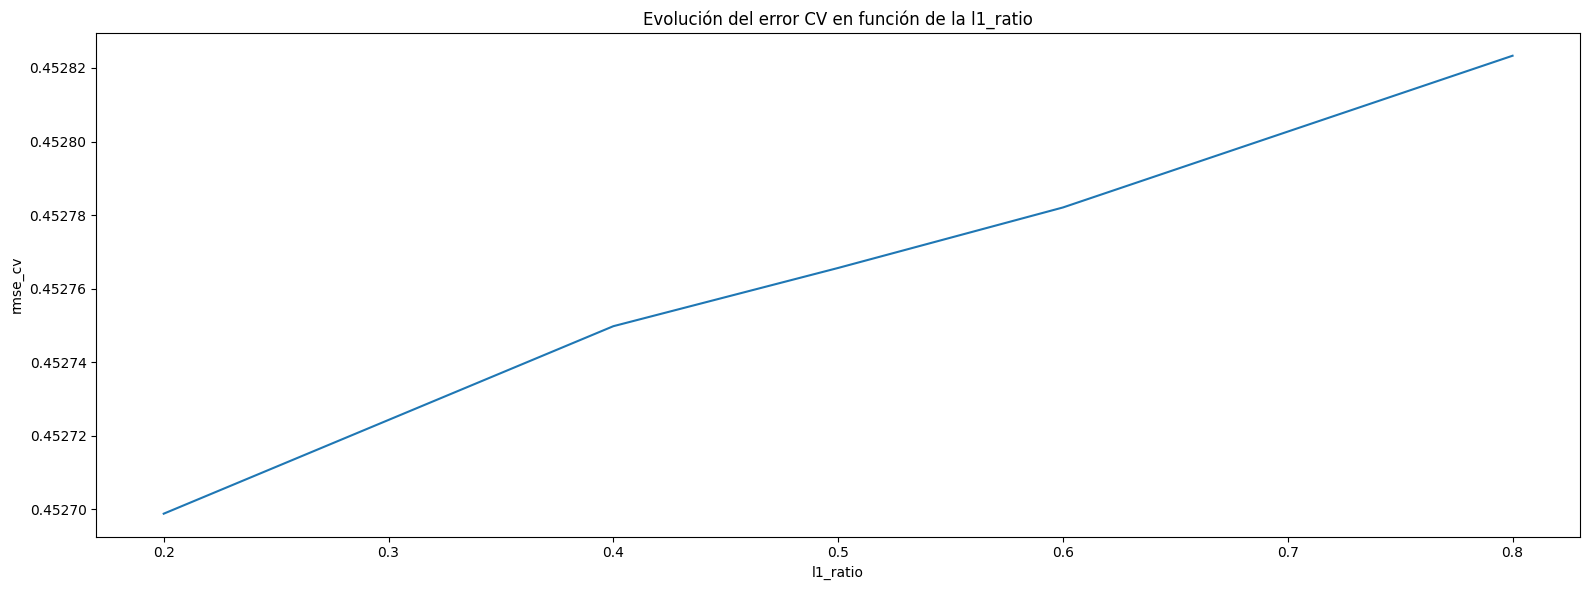

In [422]:
fig, ax = plt.subplots(figsize=(16, 6))

df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv')

plt.tight_layout()
plt.show()

In [423]:
print(f"Mejor valor de alpha encontrado: {en.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {en.l1_ratio_}")
print(f"RMSE = {min_rmse:.2f}, R² = {r2_train:.4f} en train cross-validation")

Mejor valor de alpha encontrado: 0.001
Mejor valor de l1_ratio encontrado: 0.2
RMSE = 0.45, R² = 0.7974 en train cross-validation


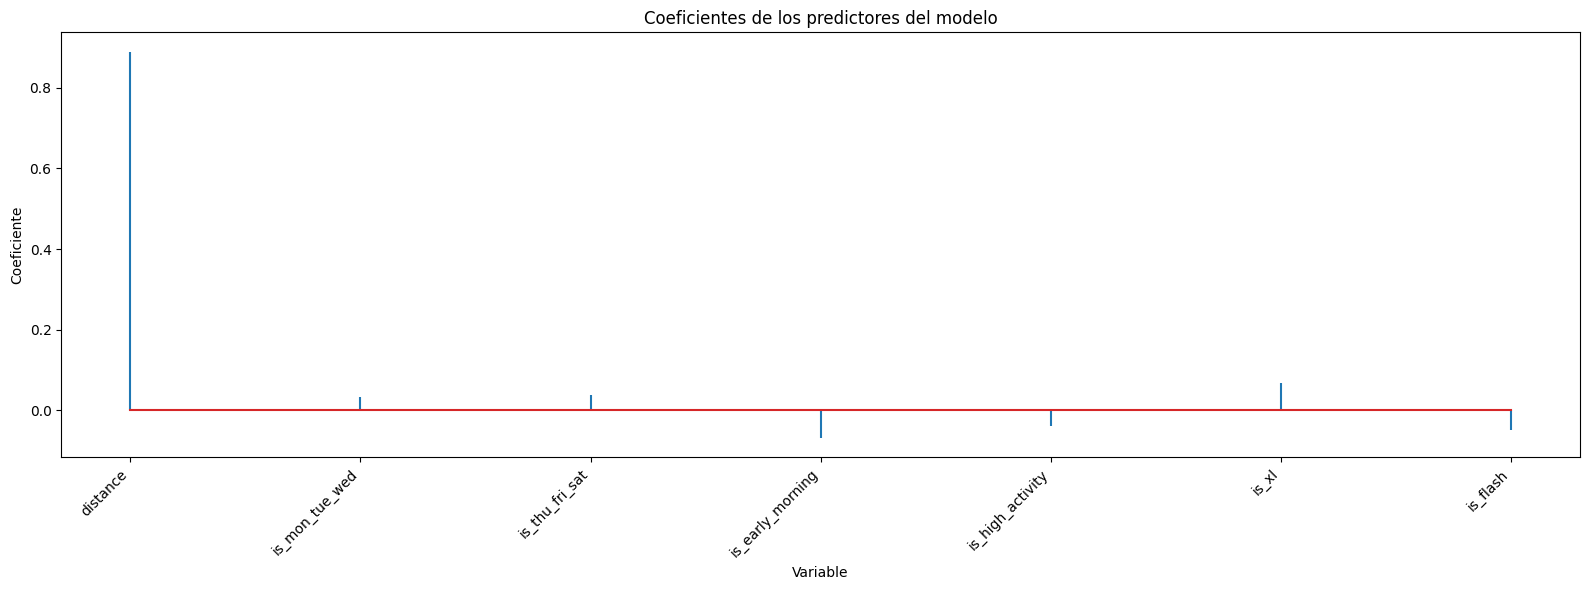

In [424]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame({'predictor': x_train.columns,'coef': en.coef_.flatten()})

fig, ax = plt.subplots(figsize=(16,6))

ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=45, ha='right', size=10)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficiente')
ax.set_title('Coeficientes de los predictores del modelo')

plt.tight_layout()
plt.show()

In [425]:
y_test_pred = en.predict(x_test)

# Reescala las predicciones y los valores reales de tarifa (variable target)
y_test_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_test_pred_original = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test_pred), y_test_pred)))[:, 1]

r2 = r2_score(y_test_original, y_test_pred_original)
mse = mean_squared_error(y_test_original, y_test_pred_original)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_original - y_test_pred_original))

rmse_modelos.append(rmse)
mae_modelos.append(mae)


print(f"Train R²: {r2_train:.4f}")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Train R²: 0.7974
R²: 0.7984
MSE: 17.5834
RMSE: 4.1933
MAE: 2.4177


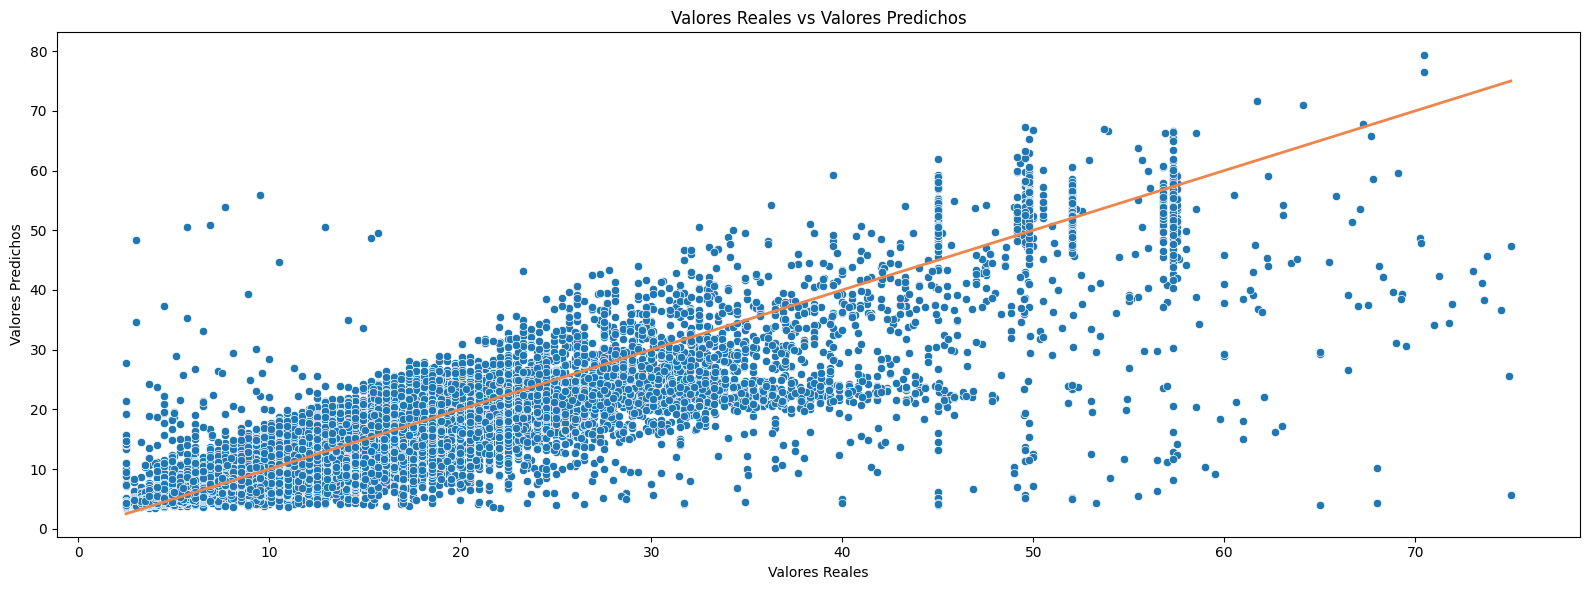

In [426]:
# Gráfico de valores reales vs predichos
plt.figure(figsize=(16, 6))

sns.scatterplot(x=y_test_original, y=y_test_pred_original)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Valores Predichos')

plt.tight_layout()
plt.show()

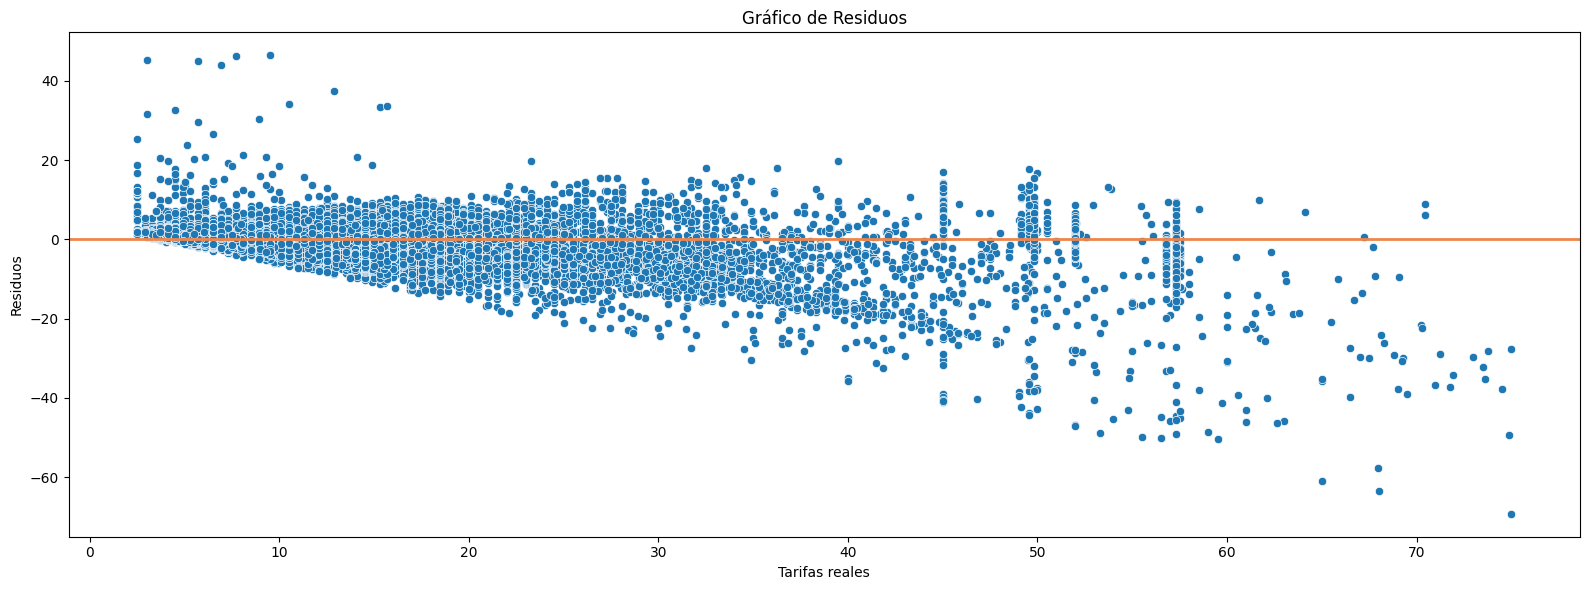

In [427]:
# Gráfico de residuos
plt.figure(figsize=(16, 6))

residuos =  y_test_pred_original - y_test_original

sns.scatterplot(x=y_test_original, y=residuos, alpha=1)
plt.axhline(0, color=sns.color_palette("muted")[1], lw=2)

plt.xlabel('Tarifas reales')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')

plt.tight_layout()
plt.show()

# Comparativa de modelos

In [428]:
#comparación de RMSE de los modelos
modelos = ['Regresión Lineal (OLS)', 'Gradient Descent', 'Stochastic GD', 'Mini-Batch GD', 'Ridge', 'Lasso', 'Elastic Net']

plt.figure(figsize=(16, 6))
sns.barplot(x=modelos, y=rmse_modelos, hue=modelos, palette='muted')
plt.ylabel('RMSE')
plt.xlabel('Modelo')
plt.title('Comparación de RMSE entre Modelos')
plt.tight_layout()
plt.show()

ValueError: All arrays must be of the same length

<Figure size 1600x600 with 0 Axes>

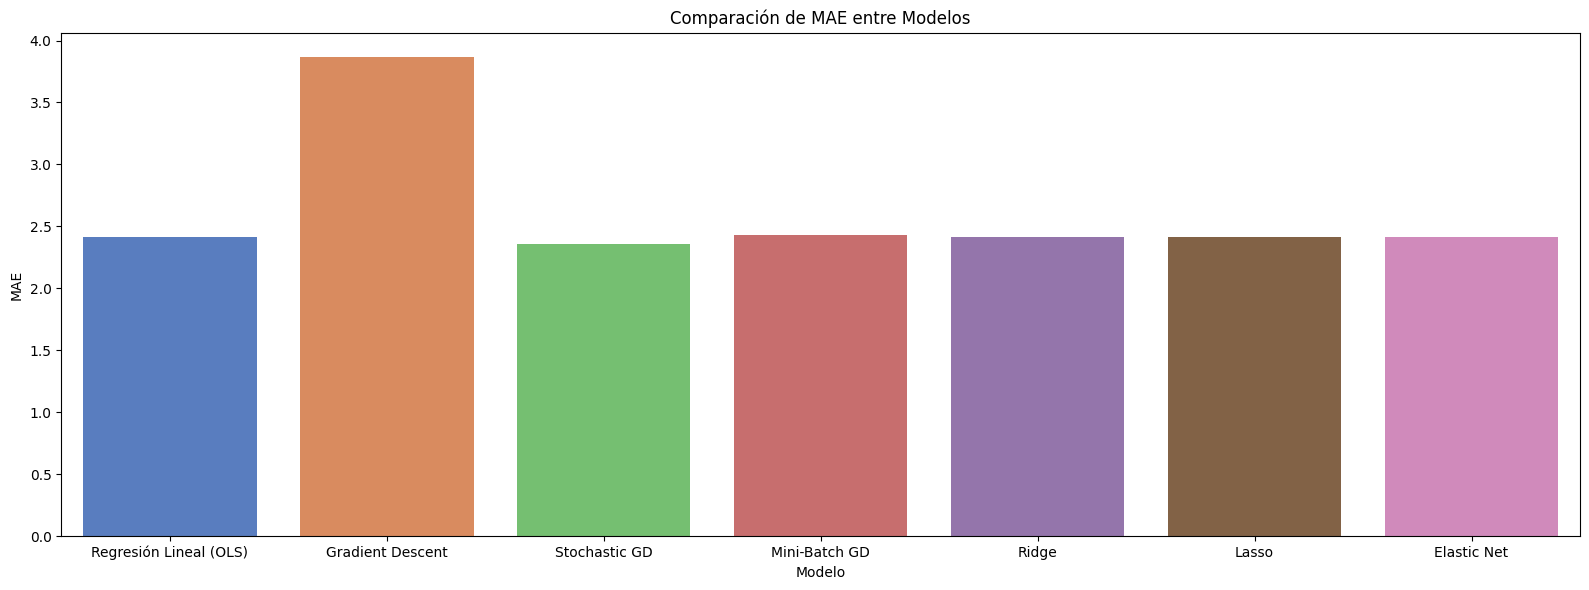

In [ ]:
#comparación de MAE de los modelos
modelos = ['Regresión Lineal (OLS)', 'Gradient Descent', 'Stochastic GD', 'Mini-Batch GD', 'Ridge', 'Lasso', 'Elastic Net']

plt.figure(figsize=(16, 6))
sns.barplot(x=modelos, y=mae_modelos, hue=modelos, palette='muted')
plt.ylabel('MAE')
plt.xlabel('Modelo')
plt.title('Comparación de MAE entre Modelos')
plt.tight_layout()
plt.show()

# Conclusión

Para lograr una predicción precisa de las tarifas, se preprocesó el dataset. Se generó la variable **distancia** usando las coordenadas de inicio y fin de cada viaje, siendo esta la más importante en nuestros modelos. Durante el proceso, **eliminamos un 2.25% de los datos** que tenían valores incorrectos en distancia y tarifa. También se imputaron **3133 datos** (0.09% del dataset) que presentaban valores absurdos, NaN o atípicos solo en una de estas variables.

Se observó que la mayoría de los viajes se realizaron en **Nueva York**, por lo que se decidió limitar el dominio del modelo a las coordenadas de esta ciudad para optimizar los resultados. 

Se generaron modelos con **regresión lineal (OLS)**. En **descenso por el gradiente** se modificaron los hiperparámetros hasta obtener convergencia en los modelos y métricas suficientemente buenas. En la etapa de **regularización**, obtuvimos con **Ridge** una sutil modificación de los coeficientes, que no llegaba a afectar las métricas. Con **Lasso** y **ElasticNet** no hubo mejoras (alpha=0).

Se obtuvieron métricas aceptables con todos los métodos de regresión lineal, siempre con una explicación de la variabilidad cercana al 80%. 
